# Libraries and Data Import

In [ ]:
import sys
%tb
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statistics
from scipy.stats import chi2_contingency
from itertools import combinations

No traceback available to show.


In [ ]:
%sh wget -P /dbfs/tmp/ https://data.nber.org/nvss/natality/csv/2023/natality2023us.csv
#read in data from NBER website

--2025-04-12 16:13:09--  https://data.nber.org/nvss/natality/csv/2023/natality2023us.csv
Resolving data.nber.org (data.nber.org)... 198.71.6.39, 198.71.6.22
Connecting to data.nber.org (data.nber.org)|198.71.6.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2212345146 (2.1G) [text/csv]
Saving to: ‘/dbfs/tmp/natality2023us.csv’

     0K .......... .......... .......... .......... ..........  0%  314K 1h54m
    50K .......... .......... .......... .......... ..........  0%  313K 1h54m
   100K .......... .......... .......... .......... ..........  0%  623K 95m50s
   150K .......... .......... .......... .......... ..........  0%  629K 86m10s
   200K .......... .......... .......... .......... ..........  0%  630K 80m22s
   250K .......... .......... .......... .......... ..........  0%  633K 76m27s
   300K .......... .......... .......... .......... ..........  0% 36.1M 65m40s
   350K .......... .......... .......... .......... ..........  0%  631K 64m36s
   

In [ ]:
#create spark session
spark = SparkSession.builder.appName('natality').getOrCreate()

#read file into spark frame
natality = spark.read.csv('file:/dbfs/tmp/natality2023us.csv', header=True, inferSchema=True)

#create SQL table to use for querying
#natality.createOrReplaceTempView('natality_tbl')

# Data Exploration

## Overview

In [ ]:
#number of rows/observations
total_deliveries = natality.count()

#number of columns/features
features = len(natality.columns)

#display counts
print(f'# of observations: {total_deliveries}')
print(f'# of features: {features}')

# of observations: 3605081
# of features: 237


In [ ]:
natality.printSchema()

root
 |-- dob_yy: integer (nullable = true)
 |-- dob_mm: integer (nullable = true)
 |-- dob_tt: integer (nullable = true)
 |-- dob_wk: integer (nullable = true)
 |-- bfacil: integer (nullable = true)
 |-- f_bfacil: integer (nullable = true)
 |-- bfacil3: integer (nullable = true)
 |-- mage_impflg: integer (nullable = true)
 |-- mage_repflg: integer (nullable = true)
 |-- mager: integer (nullable = true)
 |-- mager14: integer (nullable = true)
 |-- mager9: integer (nullable = true)
 |-- mbstate_rec: integer (nullable = true)
 |-- restatus: integer (nullable = true)
 |-- mrace31: integer (nullable = true)
 |-- mrace6: integer (nullable = true)
 |-- mrace15: integer (nullable = true)
 |-- mraceimp: integer (nullable = true)
 |-- mhispx: integer (nullable = true)
 |-- mhisp_r: integer (nullable = true)
 |-- f_mhisp: integer (nullable = true)
 |-- mracehisp: integer (nullable = true)
 |-- mar_p: string (nullable = true)
 |-- dmar: integer (nullable = true)
 |-- mar_imp: integer (nullable = 

## Data Flags and Imputed Values

In [ ]:
#the following features are various reporting flags for the dataset
flags = ['f_bfacil', 'mage_repflg', 'f_mhisp', 'f_mar_p', 'f_meduc', 'f_fhisp', 'f_feduc', 'f_mpcb', 'f_tpcv', 'f_wic', 'f_cigs_0', 'f_cigs_1', 'f_cigs_2', 'f_cigs_3', 'f_tobaco', 'f_m_ht', 'f_pwgt', 'f_dwgt', 'f_wtgain', 'f_rf_pdiab', 'f_rf_gdiab', 'f_rf_phyper', 'f_rf_ghyper', 'f_rf_eclamp', 'f_rf_ppb', 'f_rf_inft', 'f_rf_inf_drg', 'f_rf_inf_art', 'f_rf_cesar', 'f_rf_ncesar', 'f_ip_gonor', 'f_ip_syph', 'f_ip_chlam', 'f_ip_hepatb', 'f_ip_hepatc', 'f_ob_succ', 'f_ob_fail', 'f_ld_indl', 'f_ld_augm', 'f_ld_ster', 'f_ld_antb', 'f_ld_chor', 'f_ld_anes', 'f_me_pres', 'f_me_rout', 'f_me_trial', 'f_dmeth_rec', 'f_mm_mtr', 'f_mm_', 'f_mm_rupt', 'f_mm_uhyst', 'f_mm_aicu', 'f_pay', 'f_pay_rec', 'f_apgar5', 'obgest_flg', 'lmpused', 'f_ab_vent', 'f_ab_vent6', 'f_ab_niuc', 'f_ab_surfac', 'f_ab_antibio', 'f_ab_seiz', 'f_ca_anen', 'f_ca_menin', 'f_ca_heart', 'f_ca_hernia', 'f_ca_ompha', 'f_ca_gastro', 'f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom', 'f_ca_hypos', 'f_bfed']

#create a new dataframe of just the flag columns
flag_df = natality.select(*flags)

#compute the sum of each flag column, as 0 = not reported and 1 = reported
flag_df = flag_df.select(*[sum(col).alias(col) for col in flag_df.columns])

#convert the flag sum dataframe to a pandas dataframe, "melt" it, and display the
flag_df_diff = flag_df.toPandas()
flag_df_diff = flag_df_diff.melt(var_name='column', value_name='reported')

print(f"Mode: {statistics.mode(flag_df_diff['reported'])}")
flag_df_diff.describe()

Mode: 3596080


reported 
 
 
 
 
 count 
 7.600000e+01 
 
 
 mean 
 3.428594e+06 
 
 
 std 
 7.067970e+05 
 
 
 min 
 6.300000e+01 
 
 
 25% 
 3.596080e+06 
 
 
 50% 
 3.596080e+06 
 
 
 75% 
 3.596080e+06 
 
 
 max 
 3.596080e+06

In [ ]:
#find the flag count values that are not equal to 3596080 (which was the mode)
value_diff = flag_df_diff.loc[flag_df_diff['reported'] != 3596080]
value_diff.sort_values(by='reported')

column 
 reported 
 
 
 
 
 1 
 mage_repflg 
 63 
 
 
 56 
 lmpused 
 1907 
 
 
 55 
 obgest_flg 
 177357 
 
 
 52 
 f_pay 
 2276307 
 
 
 3 
 f_mar_p 
 3195972 
 
 
 75 
 f_bfed 
 3195972

The data flags with the least amount of reporting values were mage_repflg, lmpused, and obgest_flg.

In [ ]:
#list of imputed columns
imputed = ['mage_impflg', 'mraceimp', 'mar_imp', 'imp_plur', 'imp_sex', 'compgst_imp']

#create a new view of just the imputed columns
imputed_df = natality.select(*imputed)

#compute the sum of each imputed column, as 1 = imputed value
imputed_df = imputed_df.select(*[sum(col).alias(col) for col in imputed_df.columns])

#convert the imputed sum dataframe to a pandas dataframe, melt it, and display
imputed_df_diff = imputed_df.toPandas()
imputed_df_diff = imputed_df_diff.melt(var_name='column', value_name='imputed')
imputed_df_diff.sort_values(by='imputed', ascending=False, inplace=True)
imputed_df_diff['prop'] = imputed_df_diff['imputed'] / (total_deliveries)
print(imputed_df_diff)

        column  imputed      prop
1     mraceimp   290641  0.080620
5  compgst_imp    53791  0.014921
2      mar_imp     3242  0.000899
0  mage_impflg      602  0.000167
3     imp_plur      218  0.000060
4      imp_sex       88  0.000024


Mother's race was the most imputed, followed by combined gestation.

## Overall Counts

In [ ]:
#show counts of delivery method
delivery = natality.groupBy('dmeth_rec').count().toPandas()
delivery.sort_values(by='count', inplace=True, ascending=False)

#update values to correspond to readable labels, add proportion column
def update_del(row):
    if row['dmeth_rec'] == 1:
        return 'vaginal'
    elif row['dmeth_rec'] == 2:
        return 'c-section'
    elif row['dmeth_rec'] == 9:
        return 'unknown'

delivery['delivery'] = delivery.apply(update_del, axis=1)
delivery['prop'] = delivery['count'] / (delivery['count'].sum())

#display simple delivery counts
print(f'Simple Delivery Counts')
print(delivery)
print('')

#show counts of detailed delivery method
delivery_detail = natality.groupBy('rdmeth_rec').count().toPandas()
delivery_detail.sort_values(by='count', inplace=True, ascending=False)

#update values to correspond to readable labels, add proportion column
def update_del_det(row):
    if row['rdmeth_rec'] == 1:
        return 'vaginal (not after c-section)'
    elif row['rdmeth_rec'] == 2:
        return 'vaginal after previous c-section'
    elif row['rdmeth_rec'] == 3:
        return 'primary (first) c-section'
    elif row['rdmeth_rec'] == 4:
        return 'repeat c-section'
    elif row['rdmeth_rec'] == 5:
        return 'vaginal (prev c-section unknown)'
    elif row['rdmeth_rec'] == 6:
        return 'c-section (prev c-section unknown)'
    elif row['rdmeth_rec'] == 9:
        return 'not stated'

delivery_detail['delivery'] = delivery_detail.apply(update_del_det, axis=1)
delivery_detail['prop'] = delivery_detail['count'] / (delivery_detail['count'].sum())

#display detailed delivery counts
print(f'Detailed Delivery Counts')
print(delivery_detail)

Simple Delivery Counts
   dmeth_rec    count   delivery      prop
0          1  2437119    vaginal  0.676023
2          2  1165226  c-section  0.323218
1          9     2736    unknown  0.000759

Detailed Delivery Counts
   rdmeth_rec    count                            delivery      prop
0           1  2349565       vaginal (not after c-section)  0.651737
2           3   694712           primary (first) c-section  0.192704
5           4   469544                    repeat c-section  0.130245
6           2    83559    vaginal after previous c-section  0.023178
3           5     3995    vaginal (prev c-section unknown)  0.001108
4           9     2736                          not stated  0.000759
1           6      970  c-section (prev c-section unknown)  0.000269


In [ ]:
#display delivery detail based on vaginal deliveries
vag = natality_clean.where(col('dmeth_rec') == 1).groupBy('rdmeth_rec').count().toPandas()
vag.sort_values(by='count', inplace=True, ascending=False)

#apply delivery detail update function
vag['delivery'] = vag.apply(update_del_det, axis=1)
vag['prop'] = vag['count'] / (vag['count'].sum())

#view results
print('Detailed Delivery (Vaginal Only)')
print(vag)

   rdmeth_rec    count                          delivery      prop
0           1  2349565     vaginal (not after c-section)  0.964075
2           2    83559  vaginal after previous c-section  0.034286
1           5     3995  vaginal (prev c-section unknown)  0.001639


In [ ]:
#display delivery detail based on cesarean deliveries
ces = natality_clean.where(col('dmeth_rec') == 2).groupBy('rdmeth_rec').count().toPandas()
ces.sort_values(by='count', inplace=True, ascending=False)

#apply delivery detail update function
ces['delivery'] = ces.apply(update_del_det, axis=1)
ces['prop'] = ces['count'] / (ces['count'].sum())

#view results
print('Detailed Delivery (C-Section Only)')
print(ces)

   rdmeth_rec   count                            delivery      prop
1           3  694712           primary (first) c-section  0.596204
2           4  469544                    repeat c-section  0.402964
0           6     970  c-section (prev c-section unknown)  0.000832


In [ ]:
#show counts for parity
parity = natality.groupby('lbo_rec').count().toPandas()
parity.sort_values(by='lbo_rec', inplace=True)

#update values to correspond to labels
def update_parity(row):
    if row['lbo_rec'] == 9:
        return 'unknown'
    elif row['lbo_rec'] == 1:
        return 'nulliparous'
    elif row['lbo_rec'] == 2:
        return 'primiparous'
    elif row['lbo_rec'] > 2:
        return 'multiparous'

parity['parity'] = parity.apply(update_parity, axis=1)

#regroup results by parity label
parity_result = parity.groupby('parity')['count'].sum().reset_index()

#add proportion to result
parity_result['prop'] = parity_result['count'] / (parity_result['count'].sum())
parity_result.sort_values(by='prop', inplace=True, ascending=False)

#display parity
print('Parity Counts From All Deliveries, 2023')
print(parity_result)

        parity    count      prop
1  nulliparous  1410291  0.391195
2  primiparous  1129214  0.313228
0  multiparous  1055580  0.292803
3      unknown     9996  0.002773


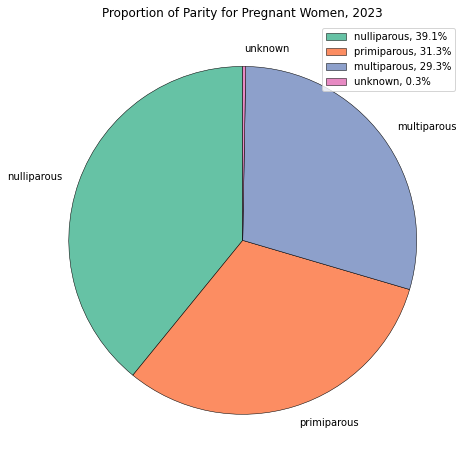

In [ ]:
#formatting info for parity piechart
plt.figure(figsize=(8,8))
colors = sns.color_palette('Set2')
plt.pie(parity_result['prop'], labels=parity_result['parity'], colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth':0.5}, startangle=90)
label_value = [f'{l}, {s:.1%}' for l, s in zip(parity_result['parity'], parity_result['prop'])]
plt.legend(labels=label_value, loc='upper right')
plt.title('Proportion of Parity for Pregnant Women, 2023')
plt.show()

In [ ]:
#show counts for term length
by_term = natality.groupby('oegest_r3').count().toPandas()
by_term.sort_values(by='oegest_r3', inplace=True)

#update values to correspond to term labels
def update_term(row):
    if row['oegest_r3'] == 1:
        return '< 37 weeks'
    elif row['oegest_r3'] == 2:
        return '37+ weeks'
    elif row['oegest_r3'] == 3:
        return 'Not stated'

#apply term function
by_term['term_label'] = by_term.apply(update_term, axis=1)

#add proportion to result
by_term['prop'] = by_term['count'] / (by_term['count'].sum())

#show counts for gestation length
gestation = natality.groupby('oegest_r10').count().toPandas()
gestation.sort_values(by='oegest_r10', inplace=True)

#update values to correspond to gestation labels
def update_gestation(row):
    if row['oegest_r10'] == 1:
        return '<20 weeks'
    elif row['oegest_r10'] == 2:
        return '20-27 weeks'
    elif row['oegest_r10'] == 3:
        return '28-31 weeks'
    elif row['oegest_r10'] == 4:
        return '32-33 weeks'
    elif row['oegest_r10'] == 5:
        return '34-36 weeks'
    elif row['oegest_r10'] == 6:
        return '37-38 weeks'
    elif row['oegest_r10'] == 7:
        return '39 weeks'
    elif row['oegest_r10'] == 8:
        return '40 weeks'
    elif row['oegest_r10'] == 9:
        return '41 weeks'
    elif row['oegest_r10'] == 10:
        return '>= 42 weeks'
    elif row['oegest_r10'] == 99:
        return 'unknown'

#apply gestation function
gestation['gestation'] = gestation.apply(update_gestation, axis=1)

#add proportion to result
gestation['prop'] = gestation['count'] / (gestation['count'].sum())

#display results
print('Data by term')
print(by_term)
print('')
print('Data by gestation')
print(gestation)

Data by term
   oegest_r3    count  term_label      prop
0          1   374643  < 37 weeks  0.103921
2          2  3227650   37+ weeks  0.895306
1          3     2788  Not stated  0.000773

Data by gestation
    oegest_r10    count    gestation      prop
0            1     1178    <20 weeks  0.000327
9            2    21961  20-27 weeks  0.006092
2            3    33215  28-31 weeks  0.009213
5            4    43085  32-33 weeks  0.011951
3            5   275204  34-36 weeks  0.076338
1            6  1074824  37-38 weeks  0.298141
7            7  1353287     39 weeks  0.375383
6            8   626094     40 weeks  0.173670
4            9   164121     41 weeks  0.045525
8           10     9324  >= 42 weeks  0.002586
10          99     2788      unknown  0.000773


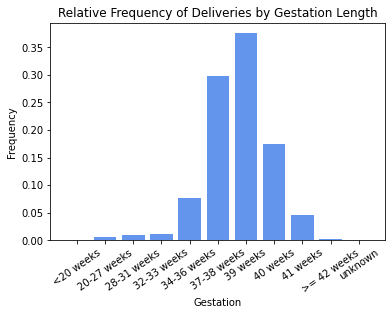

In [ ]:
#create frequency
plt.bar(gestation['gestation'], gestation['prop'], color='cornflowerblue')
plt.xticks(rotation=35)
plt.ylabel('Frequency')
plt.xlabel('Gestation')

plt.title('Relative Frequency of Deliveries by Gestation Length')
plt.show()

In [ ]:
#filter for term
term = natality.filter(col('oegest_r3') == 2).groupby('oegest_r10').count().toPandas()
term.sort_values(by='oegest_r10', inplace=True)

#apply gestation function and add proportions
term['gestation'] = term.apply(update_gestation, axis=1)
term['prop'] = term['count'] / (term['count'].sum())

#filter for preterm
preterm = natality.filter(col('oegest_r3') == 1).groupby('oegest_r10').count().toPandas()
preterm.sort_values(by='oegest_r10', inplace=True)

#apply gestation function
preterm['gestation'] = preterm.apply(update_gestation, axis=1)
preterm['prop'] = preterm['count'] / (preterm['count'].sum())

#display results
print(f'Term Deliveries')
print(term)
print(f'\nPreterm Deliveries')
print(preterm)

Term Deliveries
   oegest_r10    count    gestation      prop
0           6  1074824  37-38 weeks  0.333005
3           7  1353287     39 weeks  0.419279
2           8   626094     40 weeks  0.193978
1           9   164121     41 weeks  0.050848
4          10     9324  >= 42 weeks  0.002889

Preterm Deliveries
   oegest_r10   count    gestation      prop
0           1    1178    <20 weeks  0.003144
4           2   21961  20-27 weeks  0.058618
1           3   33215  28-31 weeks  0.088658
3           4   43085  32-33 weeks  0.115003
2           5  275204  34-36 weeks  0.734577


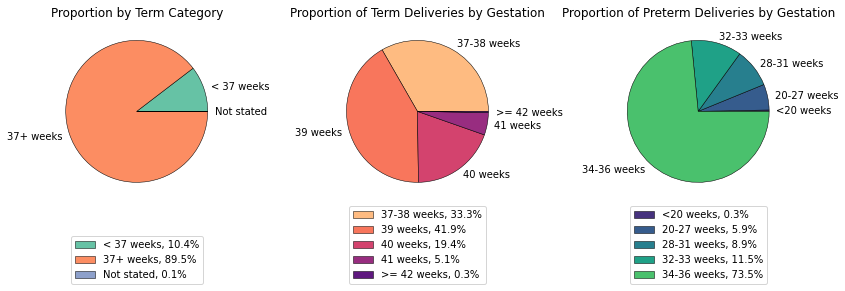

In [ ]:
#display gestation charts
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#piechart of delivery by term
color0 = sns.color_palette('Set2')
axes[0].pie(by_term['prop'], labels=by_term['term_label'], colors=color0, wedgeprops={'edgecolor':'black', 'linewidth':0.5})
label_value0 = [f'{l}, {s:.1%}' for l, s in zip(by_term['term_label'], by_term['prop'])]
axes[0].legend(labels=label_value0, loc='lower center', bbox_to_anchor=(0.5,-0.5))
axes[0].set_title('Proportion by Term Category')

#piechart of term
color1 = sns.color_palette('magma_r')
axes[1].pie(term['prop'], labels=term['gestation'], colors=color1, wedgeprops={'edgecolor':'black', 'linewidth':0.5})
label_value1 = [f'{l}, {s:.1%}' for l, s in zip(term['gestation'], term['prop'])]
axes[1].legend(labels=label_value1, loc='lower center', bbox_to_anchor=(0.5, -0.5))
axes[1].set_title('Proportion of Term Deliveries by Gestation')

#piechart of preterm
color3 = sns.color_palette('viridis')
axes[2].pie(preterm['prop'], labels=preterm['gestation'], colors=color3, wedgeprops={'edgecolor':'black', 'linewidth':0.5})
label_value2 = [f'{l}, {s:.1%}' for l, s in zip(preterm['gestation'], preterm['prop'])]
axes[2].legend(labels=label_value2, loc='lower center', bbox_to_anchor=(0.5, -0.5))
axes[2].set_title('Proportion of Preterm Deliveries by Gestation')

fig.tight_layout()

In [ ]:
#create dataframe for plurality
plurality = natality.groupby('dplural').count().toPandas()
plurality.sort_values(by='dplural', inplace=True)

#add proportion to results
plurality['prop'] = plurality['count'] / (plurality['count'].sum())

#display results
print(f'Plurality of All Deliveries, 2023')
print(plurality)

   dplural    count      prop
0        1  3491735  0.968559
3        2   110684  0.030702
1        3     2514  0.000697
2        4      148  0.000041


In [ ]:
#create dataframe for fetal presentation at delivery
presentation = natality.groupby('me_pres').count().toPandas()
presentation.sort_values(by='me_pres', inplace=True)

#add proportion to results
presentation['prop'] = presentation['count'] / (presentation['count'].sum())

#update values to correspond to presentation labels
def update_pres(row):
    if row['me_pres'] == 1:
        return 'cephalic'
    elif row['me_pres'] == 2:
        return 'breech'
    elif row['me_pres'] == 3:
        return 'other'
    elif row['me_pres'] == 9:
        return 'unknown'

#apply update function
presentation['presentation'] = presentation.apply(update_pres, axis=1)

#view results
print('Fetal Presentation at Delivery, 2023')
print(presentation)

   me_pres    count      prop presentation
0        1  3408986  0.945606     cephalic
3        2   155850  0.043231       breech
1        3    33074  0.009174        other
2        9     7171  0.001989      unknown


## Outcomes in Cesarean Deliveries

In [ ]:
'''
This portion of the code filters Cesarean deliveries in order to explore outcomes on the mother and infant.
'''
cesarean = natality.filter(col('dmeth_rec') == 2)
print(cesarean.count())

1165226


In [ ]:
#create frame counts for maternal morbidity
mat_morb = cesarean.groupby('no_mmorb').count().toPandas()

#update labels
def update_morb(row):
    if row['no_mmorb'] == 1:
        return 'no morbidity'
    elif row['no_mmorb'] == 0:
        return 'morbidity'
    elif row['no_mmorb'] == 9:
        return 'not reported'

#apply function
mat_morb['morb'] = mat_morb.apply(update_morb, axis=1)

#add proportions
mat_morb['prop'] = mat_morb['count'] / (mat_morb['count'].sum())

#view results
print('Maternal Morbidity Counts from All Deliveries, 2023')
print(mat_morb)

   no_mmorb    count          morb      prop
0         1  1145997  no morbidity  0.983498
1         9     1990  not reported  0.001708
2         0    17239     morbidity  0.014795


In [ ]:
#create frame for maternal morbidity
mat_morb_del = natality.filter(col('no_mmorb') == 0).groupby('dmeth_rec').count().toPandas()

#apply delivery labels
mat_morb_del['delivery'] = mat_morb_del.apply(update_delivery, axis=1)

#calculate proportions by delivery
mat_morb_del['prop'] = mat_morb_del['count'] / (mat_morb_del['count'].sum())

print('Maternal Morbidity Reportings by Delivery Method')
print(mat_morb_del)

Maternal Morbidity Reportings by Delivery Method
   dmeth_rec  count   delivery      prop
0          1  37571    vaginal  0.685227
1          2  17239  c-section  0.314408
2          9     20    unknown  0.000365


In [ ]:
#create frame for maternal transfusion
display(cesarean.filter(col('no_mmorb') == 0).groupby('mm_mtr').count())

mm_mtr count Y 12002 N 5237

In [ ]:
def filter_data(frame, fields):
    '''
    Filters the specified dataframe for fields, then prints the view so as to avoid creating unnecessary dataframes while applying some custom calculations and formatting.

    Args:
    Frame - the specified dataframe to filter
    Fields - a dictionary of fields to query, listed as field name (key) and title (value)

    Returns nothing, just prints the dataframe filter
    '''
    for k in fields:
        print(fields[k]) #print title of field

        #filter dataframe for desired counts
        df = frame.filter(col(k) == 'Y').groupby('dmeth_rec').count().toPandas()
        df.sort_values(by='count', inplace=True, ascending=False)

        #apply delivery labeling function
        df['delivery'] = df.apply(update_delivery, axis=1)
        df['prop'] = df['count'] / (df['count'].sum())
        print(f'{df}\n')
    pass

In [ ]:
#create dictionary for maternal morbidities to loop over for field name and print title
morbidity = {'mm_mtr':'Maternal Transfusion',
             'mm_plac':'Perineal Laceration',
             'mm_rupt':'Ruptured Uterus',
             'mm_uhyst':'Unplanned Hysterectomy',
             'mm_aicu':'Admit to ICU'}

#view maternal morbidity for whole dataset
filter_data(natality, morbidity)

Maternal Transfusion
   dmeth_rec  count   delivery      prop
1          2  12002  c-section  0.569328
0          1   9076    vaginal  0.430530
2          9      3    unknown  0.000142

Perineal Laceration
   dmeth_rec  count   delivery      prop
0          1  27709    vaginal  0.985805
1          2    384  c-section  0.013662
2          9     15    unknown  0.000534

Ruptured Uterus
   dmeth_rec  count   delivery      prop
1          2   1257  c-section  0.845326
0          1    230    vaginal  0.154674

Unplanned Hysterectomy
   dmeth_rec  count   delivery      prop
1          2   1415  c-section  0.800792
0          1    351    vaginal  0.198642
2          9      1    unknown  0.000566

Admit to ICU
   dmeth_rec  count   delivery      prop
1          2   4922  c-section  0.737931
0          1   1747    vaginal  0.261919
2          9      1    unknown  0.000150



In [ ]:
#create dictionary for newborn abnormal conditions
newborn = {'ab_aven1':'Assisted Ventilation (immediately)',
           'ab_aven6':'Assisted Ventilation >6 hours',
           'ab_nicu':'NICU Admission',
           'ab_surf':'Surfactant',
           'ab_anti':'Antibiotics for Newborn',
           'ab_seiz':'Seizures'}

#view abnormal newborn conditions for entire dataset
filter_data(natality, newborn)

Assisted Ventilation (immediately)
   dmeth_rec   count   delivery      prop
2          2  135831  c-section  0.587766
0          1   95155    vaginal  0.411754
1          9     111    unknown  0.000480

Assisted Ventilation >6 hours
   dmeth_rec  count   delivery      prop
2          2  49131  c-section  0.648183
0          1  26636    vaginal  0.351408
1          9     31    unknown  0.000409

NICU Admission
   dmeth_rec   count   delivery      prop
2          2  204317  c-section  0.579626
0          1  148000    vaginal  0.419861
1          9     181    unknown  0.000513

Surfactant
   dmeth_rec  count   delivery      prop
1          2  12942  c-section  0.707677
0          1   5338    vaginal  0.291885
2          9      8    unknown  0.000437

Antibiotics for Newborn
   dmeth_rec  count   delivery      prop
2          2  36329  c-section  0.529593
0          1  32242    vaginal  0.470014
1          9     27    unknown  0.000394

Seizures
   dmeth_rec  count   delivery      prop
1 

The above observations for the newborn outcomes are based solely on all available births, which includes mothers or fetuses at higher risk of complications.

## Creating frame of low-risk pregnancies

In [ ]:
'''
This portion of the code filters for low-risk women based on the defined methodology according to Healthy People 2023.

Low-risk female:
    - nulliparous (never given birth before - per the user guide, "parity indicates how many live births a mother has had")
    - full-term (>=37 weeks gestation, based on ob estimate at delivery)
    - singleton pregnancy (not multiple, e.g. twins or higher)
    - vertex fetus (head facing downward/aka cephalic, opposite of breech)

The corresponding NVSS fields are:
    - nulliparous: lbo_rec = 1
    - full-term: oegest_r3 = 2 (37 weeks & over)
    - singleton pregnancy: dplural = 1
    - vertex: me_pres = 1
'''
low_risk = natality.filter(
    (col('lbo_rec') == 1) &
    (col('oegest_r3') == 2) &
    (col('dplural') == 1) &
    (col('me_pres') == 1)
)

In [ ]:
def update_delivery(row):
    '''
    This function applies a human-readable label to the delivery method.

    Arg: row (of dataframe), this is easiest by calling df_name.apply(update_delivery, axis=1)

    Returns: label (string, either vaginal or c-section)
    '''
    if row['dmeth_rec'] == 1:
        delivery_label = 'vaginal'
    elif row['dmeth_rec'] == 2:
        delivery_label = 'c-section'
    return delivery_label

In [ ]:
delivery_label = ['vaginal', 'c-section']

In [ ]:
#display count of low-risk pregnancies
print(f'Low-risk pregnancy deliveries in 2023: {low_risk.count()}, {(low_risk.count() / total_deliveries)*100:.2f}% of total deliveries')

Low-risk pregnancy deliveries in 2023: 1218732, 33.81% of total deliveries


In [ ]:
#view maternal morbidity reports in low-risk mothers
filter_data(low_risk, morbidity)

Maternal Transfusion
   dmeth_rec  count   delivery      prop
0          1   4048    vaginal  0.589314
1          2   2820  c-section  0.410540
2          9      1    unknown  0.000146

Perineal Laceration
   dmeth_rec  count   delivery      prop
0          1  20792    vaginal  0.992885
1          2    140  c-section  0.006685
2          9      9    unknown  0.000430

Ruptured Uterus
   dmeth_rec  count   delivery      prop
1          2     86  c-section  0.623188
0          1     52    vaginal  0.376812

Unplanned Hysterectomy
   dmeth_rec  count   delivery      prop
1          2    166  c-section  0.703390
0          1     69    vaginal  0.292373
2          9      1    unknown  0.004237

Admit to ICU
   dmeth_rec  count   delivery      prop
1          2    942  c-section  0.624254
0          1    567    vaginal  0.375746



In [ ]:
#view newborn abnormal outcomes in low-risk mothers
filter_data(low_risk, newborn)

Assisted Ventilation (immediately)
   dmeth_rec  count   delivery      prop
0          1  33963    vaginal  0.550838
1          2  27681  c-section  0.448951
2          9     13    unknown  0.000211

Assisted Ventilation >6 hours
   dmeth_rec  count   delivery      prop
0          1   6457    vaginal  0.546139
1          2   5365  c-section  0.453777
2          9      1    unknown  0.000085

NICU Admission
   dmeth_rec  count   delivery      prop
0          1  40107    vaginal  0.565588
1          2  30786  c-section  0.434144
2          9     19    unknown  0.000268

Surfactant
   dmeth_rec  count   delivery      prop
0          1    674    vaginal  0.553366
1          2    544  c-section  0.446634

Antibiotics for Newborn
   dmeth_rec  count   delivery      prop
0          1  10086    vaginal  0.585510
1          2   7137  c-section  0.414316
2          9      3    unknown  0.000174

Seizures
   dmeth_rec  count   delivery      prop
0          1    317    vaginal  0.562057
1         

In [ ]:
#make a new dataframe for delivery method unknown
natality_unk = low_risk.filter(col('dmeth_rec') == 9)

#make a new dataframe that excludes unknown delivery method, as "truth" is either vaginal delivery or cesarean delivery
low_risk_df = low_risk.filter(col('dmeth_rec') != 9)

#display results
print(f'Low-risk Delivery Type Known: {low_risk_df.count()}')
print(f'Low-risk Delivery Type Unknown: {natality_unk.count()}')

Low-risk Delivery Type Known: 1218318
Low-risk Delivery Type Unknown: 414


   dmeth_rec   count      prop   delivery
0          1  893899  0.733716    vaginal
1          2  324419  0.266284  c-section


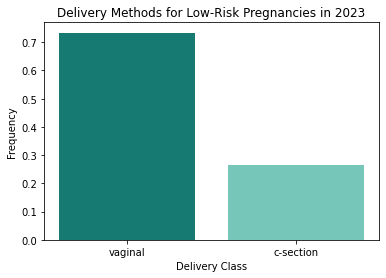

In [ ]:
#view low-risk delivery classifications
del_lowrisk = low_risk_df.groupby('dmeth_rec').count().toPandas()
del_lowrisk['prop'] = del_lowrisk['count'] / (del_lowrisk['count'].sum())

#apply delivery label
def update_delivery(row):
    if row['dmeth_rec'] == 1:
        return 'vaginal'
    elif row['dmeth_rec'] == 2:
        return 'c-section'

del_lowrisk['delivery'] = del_lowrisk.apply(update_delivery, axis=1)

#view results
print('Delivery Methods of Low-Risk Pregnancies')
print(del_lowrisk)

#display classification
colors = sns.color_palette('BrBG_r')
plt.bar(del_lowrisk['delivery'], del_lowrisk['prop'], color=colors)
plt.ylabel('Frequency')
plt.xlabel('Delivery Class')

plt.title('Delivery Methods for Low-Risk Pregnancies in 2023')
plt.show()

In [ ]:
#count proportions of hospital births for all natality data
hospital_all = natality.filter(col('bfacil') == 1).count()
print(f'Hospital deliveries among entire population: {(hospital_all / total_deliveries)*100:.2f}%\n')

#count proportions of hospital births for low-risk women
hospital_lowrisk = low_risk_df.filter(col('bfacil') == 1).count()
print(f'Low-risk hospital deliveries')
print(f'{(hospital_lowrisk / hospital_all) * 100:.2f}% of all hospital deliveries were low risk')
print(f'{(hospital_lowrisk / low_risk_df.count()) * 100:.2f}% of all low-risk deliveries took place in hospital')

Hospital deliveries among entire population: 97.67%

Low-risk hospital deliveries
34.11% of all hospital deliveries were low risk
98.58% of all low-risk deliveries took place in hospital


In [ ]:
#create dataframe for birth facility of all natality data
bfacil = natality.filter(col('bfacil')!=1).groupBy('bfacil').count().toPandas()

#create function for updating birth facility
def update_bfacil(row):
    if row['bfacil'] == 1:
        return 'hospital'
    elif row['bfacil'] == 2:
        return 'freestanding birth center'
    elif row['bfacil'] == 3:
        return 'home (intended)'
    elif row['bfacil'] == 4:
        return 'home (not intended)'
    elif row['bfacil'] == 5:
        return 'home (unknown intent)'
    elif row['bfacil'] == 6:
        return 'clinic/doctors office'
    elif row['bfacil'] == 7:
        return 'other'
    elif row['bfacil'] == 9:
        return 'unknown'

#apply function to dataframe
bfacil['facility'] = bfacil.apply(update_bfacil, axis=1)

#add proportion column
bfacil['prop'] = bfacil['count'] / (bfacil['count'].sum())
bfacil.sort_values(by='count', inplace=True, ascending=False)

#create dataframe for low-risk birth facilities
low_risk_fac = low_risk.filter(col('bfacil')!=1).groupby('bfacil').count().toPandas()
low_risk_fac['facility'] = low_risk_fac.apply(update_bfacil, axis=1)
low_risk_fac['prop'] = low_risk_fac['count'] / (low_risk_fac['count'].sum())
low_risk_fac.sort_values(by='count', inplace=True, ascending=False)

#display results
print('Non-Hospital Birth Facilities, All Pregnancies, 2023')
print(bfacil)
print()
print('Non-Hospital Birth Facilities, Low-Risk Pregnancies, 2023')
print(low_risk_fac)

In [ ]:
#create function for updating birth facility
def update_bfacil(row):
    if row['bfacil'] == 1:
        return 'hospital'
    elif row['bfacil'] == 2:
        return 'freestanding birth center'
    elif row['bfacil'] == 3:
        return 'home (intended)'
    elif row['bfacil'] == 4:
        return 'home (not intended)'
    elif row['bfacil'] == 5:
        return 'home (unknown intent)'
    elif row['bfacil'] == 6:
        return 'clinic/doctors office'
    elif row['bfacil'] == 7:
        return 'other'
    elif row['bfacil'] == 9:
        return 'unknown'

In [ ]:
#create dataframe for low-risk birth facilities
low_risk_fac = low_risk.groupby('bfacil', 'dmeth_rec').count().toPandas()
low_risk_fac['facility'] = low_risk_fac.apply(update_bfacil, axis=1)
low_risk_fac['prop'] = low_risk_fac['count'] / (low_risk_fac['count'].sum())
low_risk_fac.sort_values(by='count', inplace=True, ascending=False)

In [ ]:
sns.barplot(data=low_risk_fac, x='bfacil', y='percent', hue='dmeth_rec', ax=axes[0, 0], palette='magma')
handlesa, labelsa = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(handlesa, delivery_label)
axes[0, 0].set_title('6 Race Categories')
axes[0, 0].set_xlabel('')


## Exploring Mother's Age

### Mother's Age as a Continuous Variable

In [ ]:
#create dataframe of mother's age and delivery method
age = low_risk_df.select('mager', 'dmeth_rec').toPandas()

#view summary of age
print(age['mager'].describe().drop('count').apply('{:.2f}'.format))

mean    27.36
std      5.84
min     12.00
25%     23.00
50%     27.00
75%     32.00
max     50.00
Name: mager, dtype: object


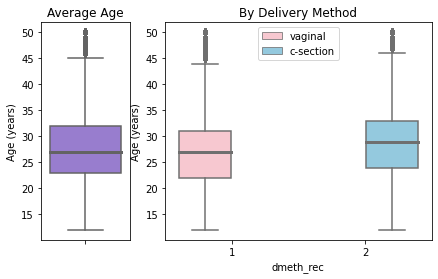

In [ ]:
#set up two subplots for mother's age comparisons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'width_ratios':[1, 3]})
plt.title('Boxplot of Mothers Age')

#display boxplot of mother's age
sns.boxplot(y='mager', data=age, ax=ax1, palette=['mediumpurple'], medianprops={'linewidth':3})
ax1.set_ylabel('Age (years)')
ax1.set_title('Average Age')

#display boxplot of mother's age by delivery method
sns.boxplot(x='dmeth_rec', y='mager', hue='dmeth_rec', data=age, ax=ax2, palette=['pink', 'skyblue'], medianprops={'linewidth' : 3})
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, delivery_label, loc='upper center')
ax2.set_ylabel('Age (years)')
ax2.set_title('By Delivery Method')

#view plots
plt.show()

In [ ]:
#show summary of age by vaginal delivery
#age_vag = age[age['dmeth_rec'] == 1].describe().drop('count').round(2)
print('Descriptive Age Stats for Vaginal Delivery')
print(age[age['dmeth_rec'] == 1].describe().round(2))
print('')

#show summary of age by c-section
#age_ces = age[age['dmeth_rec'] == 2].describe().drop('count').round(2)
print('Descriptive Age Stats for C-Section')
print(age[age['dmeth_rec'] == 2].describe().round(2))

Descriptive Age Stats for Vaginal Delivery
           mager  dmeth_rec
count  893899.00   893899.0
mean       26.77        1.0
std         5.68        0.0
min        12.00        1.0
25%        22.00        1.0
50%        27.00        1.0
75%        31.00        1.0
max        50.00        1.0

Descriptive Age Stats for C-Section
           mager  dmeth_rec
count  324419.00   324419.0
mean       28.99        2.0
std         5.97        0.0
min        12.00        2.0
25%        24.00        2.0
50%        29.00        2.0
75%        33.00        2.0
max        50.00        2.0


### Mother's Age as a Categorical Variable

In [ ]:
#create df for 14 age groups
mager14_df = low_risk.groupBy('dmeth_rec', 'mager14').count().toPandas()
mager14_df['prop'] = mager14_df['count'] / mager14_df.groupby('mager14')['count'].transform('sum')
mager14_df['percent'] = (mager14_df['prop'] * 100).round(1)

#create df for 9 age groups
mager9_df = low_risk.groupBy('dmeth_rec', 'mager9').count().toPandas()
mager9_df['prop'] = mager9_df['count'] / mager9_df.groupby('mager9')['count'].transform('sum')
mager9_df['percent'] = (mager9_df['prop'] * 100).round(1)

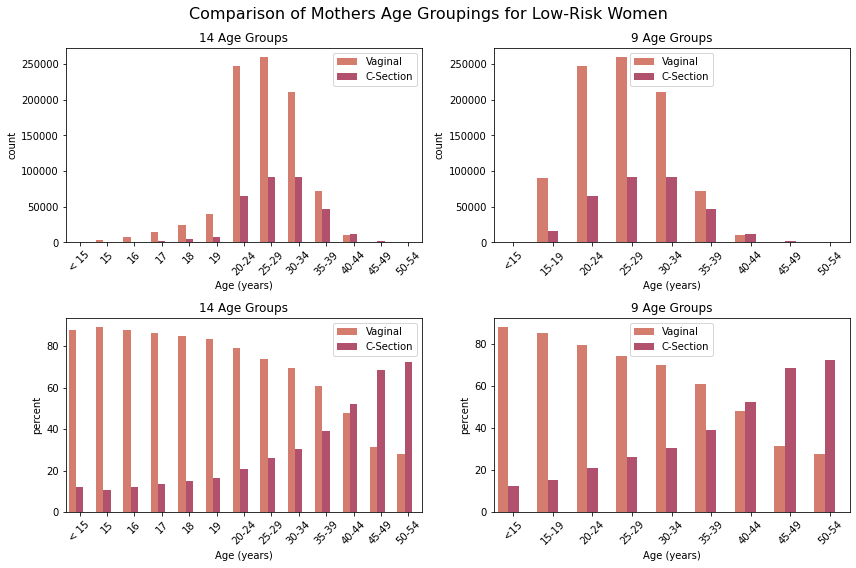

In [ ]:
#set up four subplots for mother's age comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparison of Mothers Age Groupings for Low-Risk Women', fontsize=16)

#create labels for delivery method
delivery_label = ['Vaginal', 'C-Section']

#create labels for age groups
age_14 = ['< 15', '15', '16', '17', '18', '19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54']
age_9 = ['<15', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54']

#create bar plot of 14 age count
sns.barplot(data=mager14_df, x='mager14', y='count', hue='dmeth_rec', ax=axes[0, 0], palette='flare')
axes[0, 0].set_xticklabels(age_14, rotation=45)
handlesa, labelsa = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(handlesa, delivery_label)
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_title('14 Age Groups')

#create barplot of 9 age count
sns.barplot(data=mager9_df, x='mager9', y='count', hue='dmeth_rec', ax=axes[0, 1], palette='flare')
axes[0, 1].set_xticklabels(age_9, rotation=45)
handlesb, labelsb = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(handlesb, delivery_label)
axes[0, 1].set_xlabel('Age (years)')
axes[0, 1].set_title('9 Age Groups')

#create bar plot of 14 age percent
sns.barplot(data=mager14_df, x='mager14', y='percent', hue='dmeth_rec', ax=axes[1, 0], palette='flare')
axes[1, 0].set_xticklabels(age_14, rotation=45)
handlesc, labelsc = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(handlesc, delivery_label)
axes[1, 0].set_xlabel('Age (years)')
axes[1, 0].set_title('14 Age Groups')

#create barplot of 9 age percent
sns.barplot(data=mager9_df, x='mager9', y='percent', hue='dmeth_rec', ax=axes[1, 1], palette='flare')
axes[1, 1].set_xticklabels(age_9, rotation=45)
handlesd, labelsd = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(handlesd, delivery_label)
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_title('9 Age Groups')

plt.tight_layout()
plt.show()

Comparing the two age groupings, the plot of the 14-age groups seems to be skewed, however, I do note that ages under 20 are reported as single-year increments, whereas the 9-age groups reportes those under 20 as 1 group.

## Comparing Race/Hispanic Origin to Proportion of C-Section deliveries
mrace6, mrace15, mhisp_r, mracehisp

In [ ]:
#create dataframe for mrace6
mrace6 = low_risk_df.groupby('dmeth_rec','mrace6').count().toPandas()
mrace6.sort_values(by='mrace6', inplace=True)

#create label function
def update_race6(row):
    if row['mrace6'] == 1:
        return 'white'
    elif row['mrace6'] == 2:
        return 'black'
    elif row['mrace6'] == 3:
        return 'AIAN'
    elif row['mrace6'] == 4:
        return 'Asian'
    elif row['mrace6'] == 5:
        return 'NHOPI'
    elif row['mrace6'] == 6:
        return 'multi-racial'

#apply updated race function
mrace6['race'] = mrace6.apply(update_race6, axis=1)

#add proportion of delivery method
mrace6['prop'] = mrace6['count'] / mrace6.groupby('mrace6')['count'].transform('sum')
mrace6['percent'] = (mrace6['prop'] * 100).round(1)

#print(mrace6)

In [ ]:
#create dataframe for mrace15
mrace15 = low_risk_df.groupby('dmeth_rec','mrace15').count().toPandas()
mrace15.sort_values(by='mrace15', inplace=True)

#create label function
def update_race15(row):
    if row['mrace15'] == 1:
        return 'white'
    elif row['mrace15'] == 2:
        return 'black'
    elif row['mrace15'] == 3:
        return 'AIAN'
    elif row['mrace15'] == 4:
        return 'Asian Indian'
    elif row['mrace15'] == 5:
        return 'Chinese'
    elif row['mrace15'] == 6:
        return 'Filipino'
    elif row['mrace15'] == 7:
        return 'Japanese'
    elif row['mrace15'] == 8:
        return 'Korean'
    elif row['mrace15'] == 9:
        return 'Vietnamese'
    elif row['mrace15'] == 10:
        return 'Other Asian'
    elif row['mrace15'] == 11:
        return 'Hawaiian'
    elif row['mrace15'] == 12:
        return 'Guamanian'
    elif row['mrace15'] == 13:
        return 'Samoan'
    elif row['mrace15'] == 14:
        return 'Other Pac Isl'
    elif row['mrace15'] == 15:
        return 'multi-racial'

#apply update function
mrace15['race'] = mrace15.apply(update_race15, axis=1)

#add proportion of delivery method
mrace15['prop'] = mrace15['count'] / mrace15.groupby('mrace15')['count'].transform('sum')
mrace15['percent'] = (mrace15['prop'] * 100).round(1)

#display
#print(mrace15)

In [ ]:
#create frame for mhisp_r
mhisp_r = low_risk_df.groupby('dmeth_rec', 'mhisp_r').count().toPandas()
mhisp_r.sort_values(by='mhisp_r', inplace=True)

#create update function
def update_hisp(row):
    if row['mhisp_r'] == 0:
        return 'Non-Hispanic'
    elif row['mhisp_r'] == 1:
        return 'Mexican'
    elif row['mhisp_r'] == 2:
        return 'Puerto Rican'
    elif row['mhisp_r'] == 3:
        return 'Cuban'
    elif row['mhisp_r'] == 4:
        return 'Cent/South Amer'
    elif row['mhisp_r'] == 5:
        return 'Other & Unk Hisp'
    elif row['mhisp_r'] == 9:
        return 'Not Stated'

#apply update function
mhisp_r['hisp'] = mhisp_r.apply(update_hisp, axis=1)

#add proportion of delivery method
mhisp_r['prop'] = mhisp_r['count'] / mhisp_r.groupby('mhisp_r')['count'].transform('sum')
mhisp_r['percent'] = (mhisp_r['prop'] * 100).round(1)

#view
#print(mhisp_r)

In [ ]:
#create frame for mracehisp
mracehisp = low_risk_df.groupby('dmeth_rec', 'mracehisp').count().toPandas()
mracehisp.sort_values(by='mracehisp', inplace=True)

#create update function
def update_racehisp(row):
    if row['mracehisp'] == 1:
        return 'NH white'
    elif row['mracehisp'] == 2:
        return 'NH black'
    elif row['mracehisp'] == 3:
        return 'NH AIAN'
    elif row['mracehisp'] == 4:
        return 'NH Asian'
    elif row['mracehisp'] == 5:
        return 'NH NHOPI'
    elif row['mracehisp'] == 6:
        return 'NH multiracial'
    elif row['mracehisp'] == 7:
        return 'Hispanic'
    elif row['mracehisp'] == 8:
        return 'Unk'

#apply update function
mracehisp['race_hisp'] = mracehisp.apply(update_racehisp, axis=1)

#add proportion of delivery method
mracehisp['prop'] = mracehisp['count'] / mracehisp.groupby('mracehisp')['count'].transform('sum')
mracehisp['percent'] = (mracehisp['prop'] * 100).round(1)

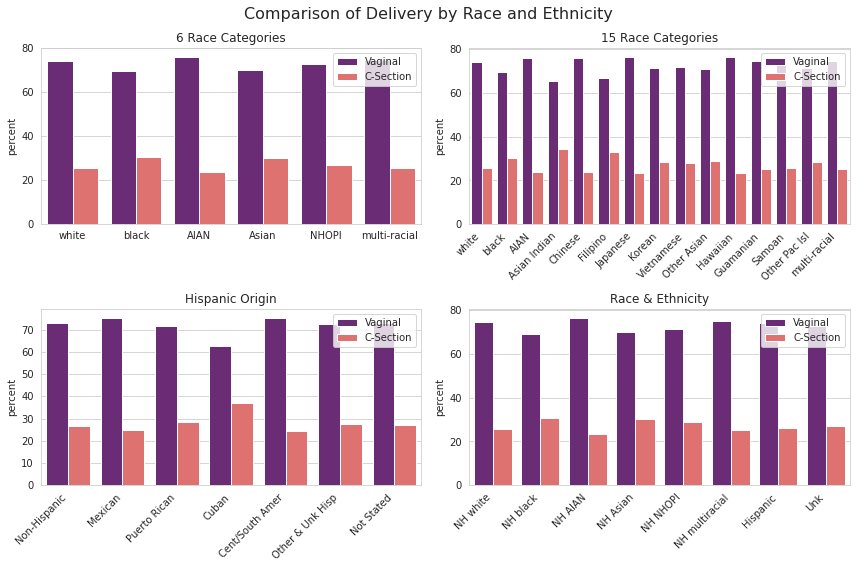

In [ ]:
#set up four subplots for mother's age comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparison of Delivery by Race and Ethnicity', fontsize=16)

#create labels for delivery method
delivery_label = ['Vaginal', 'C-Section']

#create bar plot of race 6
sns.barplot(data=mrace6, x='race', y='percent', hue='dmeth_rec', ax=axes[0, 0], palette='magma')
handlesa, labelsa = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(handlesa, delivery_label)
axes[0, 0].set_title('6 Race Categories')
axes[0, 0].set_xlabel('')

#create barplot of race 15
sns.barplot(data=mrace15, x='race', y='percent', hue='dmeth_rec', ax=axes[0, 1], palette='magma')
handlesb, labelsb = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(handlesb, delivery_label)
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_title('15 Race Categories')
axes[0, 1].set_xlabel('')

#create barplot of hispanic origin
sns.barplot(data=mhisp_r, x='hisp', y='percent', hue='dmeth_rec', ax=axes[1, 0], palette='magma')
handlesc, labelsc = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(handlesc, delivery_label)
plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].set_title('Hispanic Origin')
axes[1, 0].set_xlabel('')

#create barplot of race and ethnicity
sns.barplot(data=mracehisp, x='race_hisp', y='percent', hue='dmeth_rec', ax=axes[1,1], palette='magma')
handlesd, labelsd = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(handlesd, delivery_label)
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].set_title('Race & Ethnicity')
axes[1, 1].set_xlabel('')

plt.tight_layout()

## Comparing Various Predictors to Proportion of C-Section Deliveries

In [ ]:
#create df of month
month_df = low_risk_df.groupBy('dmeth_rec', 'dob_mm').count().toPandas()
month_df.sort_values(by='dob_mm', inplace=True, ascending=True)

#create df of day
day_df = low_risk_df.groupBy('dmeth_rec', 'dob_wk').count().toPandas()
day_df.sort_values(by='dob_wk', inplace=True, ascending=True)

#create df of paternity acknowledgement
pat_df = low_risk_df.groupBy('dmeth_rec', 'mar_p').count().toPandas()
pat_df.sort_values(by='mar_p', inplace=True, ascending=True)

#create df of marital status
marital_df = low_risk_df.groupBy('dmeth_rec', 'dmar').count().toPandas()
marital_df.sort_values(by='dmar', inplace=True, ascending=True)

#create df of education
education_df = low_risk_df.groupBy('dmeth_rec', 'meduc').count().toPandas()
education_df.sort_values(by='meduc', inplace=True, ascending=True)

#create df of prenatal care
prenatal_df = low_risk_df.groupBy('dmeth_rec', 'precare5').count().toPandas()
prenatal_df.sort_values(by='precare5', inplace=True, ascending=True)

#create df of wic
wic_df = low_risk_df.groupBy('dmeth_rec', 'wic').count().toPandas()
wic_df.sort_values(by='wic', inplace=True, ascending=True)

#create df of smoking
smoking_df = low_risk_df.groupBy('dmeth_rec', 'cig_rec').count().toPandas()
smoking_df.sort_values(by='cig_rec', inplace=True, ascending=True)

#create df of bmi
bmi_df = low_risk_df.groupBy('dmeth_rec', 'bmi_r').count().toPandas()
bmi_df.sort_values(by='bmi_r', inplace=True, ascending=True)

#create df of payer
payer_df = low_risk_df.groupBy('dmeth_rec', 'pay').count().toPandas()
payer_df.sort_values(by='pay', inplace=True, ascending=True)

#create df of baby's sex
sex_df = low_risk_df.groupBy('dmeth_rec', 'sex').count().toPandas()
sex_df.sort_values(by='sex', inplace=True, ascending=True)

#create df of obstetric estimate
obs_df = low_risk_df.groupBy('dmeth_rec', 'oegest_r10').count().toPandas()
obs_df.sort_values(by='oegest_r10', inplace=True, ascending=True)

In [ ]:
#add proportion of delivery method to month df
month_df['prop'] = month_df['count'] / month_df.groupby('dob_mm')['count'].transform('sum')
month_df['percent'] = (month_df['prop'] * 100).round(1)

#add proportion of delivery method to day df
day_df['prop'] = day_df['count'] / day_df.groupby('dob_wk')['count'].transform('sum')
day_df['percent'] = (day_df['prop'] * 100).round(1)

#add proportion of delivery method to paternal df, mar_p
pat_df['prop'] = pat_df['count'] / pat_df.groupby('mar_p')['count'].transform('sum')
pat_df['percent'] = (pat_df['prop'] * 100).round(1)

#add proportion of delivery method to marital df, dmar
marital_df['prop'] = marital_df['count'] / marital_df.groupby('dmar')['count'].transform('sum')
marital_df['percent'] = (marital_df['prop'] * 100).round(1)

#add proportion of delivery method to education df, meduc
education_df['prop'] = education_df['count'] / education_df.groupby('meduc')['count'].transform('sum')
education_df['percent'] = (education_df['prop'] * 100).round(1)

#add proportion of delivery method to prenatal df, precare5
prenatal_df['prop'] = prenatal_df['count'] / prenatal_df.groupby('precare5')['count'].transform('sum')
prenatal_df['percent'] = (prenatal_df['prop'] * 100).round(1)

#add proportion of delivery method to wic df, wic
wic_df['prop'] = wic_df['count'] / wic_df.groupby('wic')['count'].transform('sum')
wic_df['percent'] = (wic_df['prop'] * 100).round(1)

#add proportion of delivery method to smoking df, cig_rec
smoking_df['prop'] = smoking_df['count'] / smoking_df.groupby('cig_rec')['count'].transform('sum')
smoking_df['percent'] = (smoking_df['prop'] * 100).round(1)

#add proportion of delivery method to bmi df, bmi_r
bmi_df['prop'] = bmi_df['count'] / bmi_df.groupby('bmi_r')['count'].transform('sum')
bmi_df['percent'] = (bmi_df['prop'] * 100).round(1)

#add proportion of delivery method to payer df, payer
payer_df['prop'] = payer_df['count'] / payer_df.groupby('pay')['count'].transform('sum')
payer_df['percent'] = (payer_df['prop'] * 100).round(1)

#add proportion of delivery method to sex df, sex
sex_df['prop'] = sex_df['count'] / sex_df.groupby('sex')['count'].transform('sum')
sex_df['percent'] = (sex_df['prop'] * 100).round(1)

#add proportion of delivery method to gestation df, gestrec10
obs_df['prop'] = obs_df['count'] / obs_df.groupby('oegest_r10')['count'].transform('sum')
obs_df['percent'] = (obs_df['prop'] * 100).round(1)

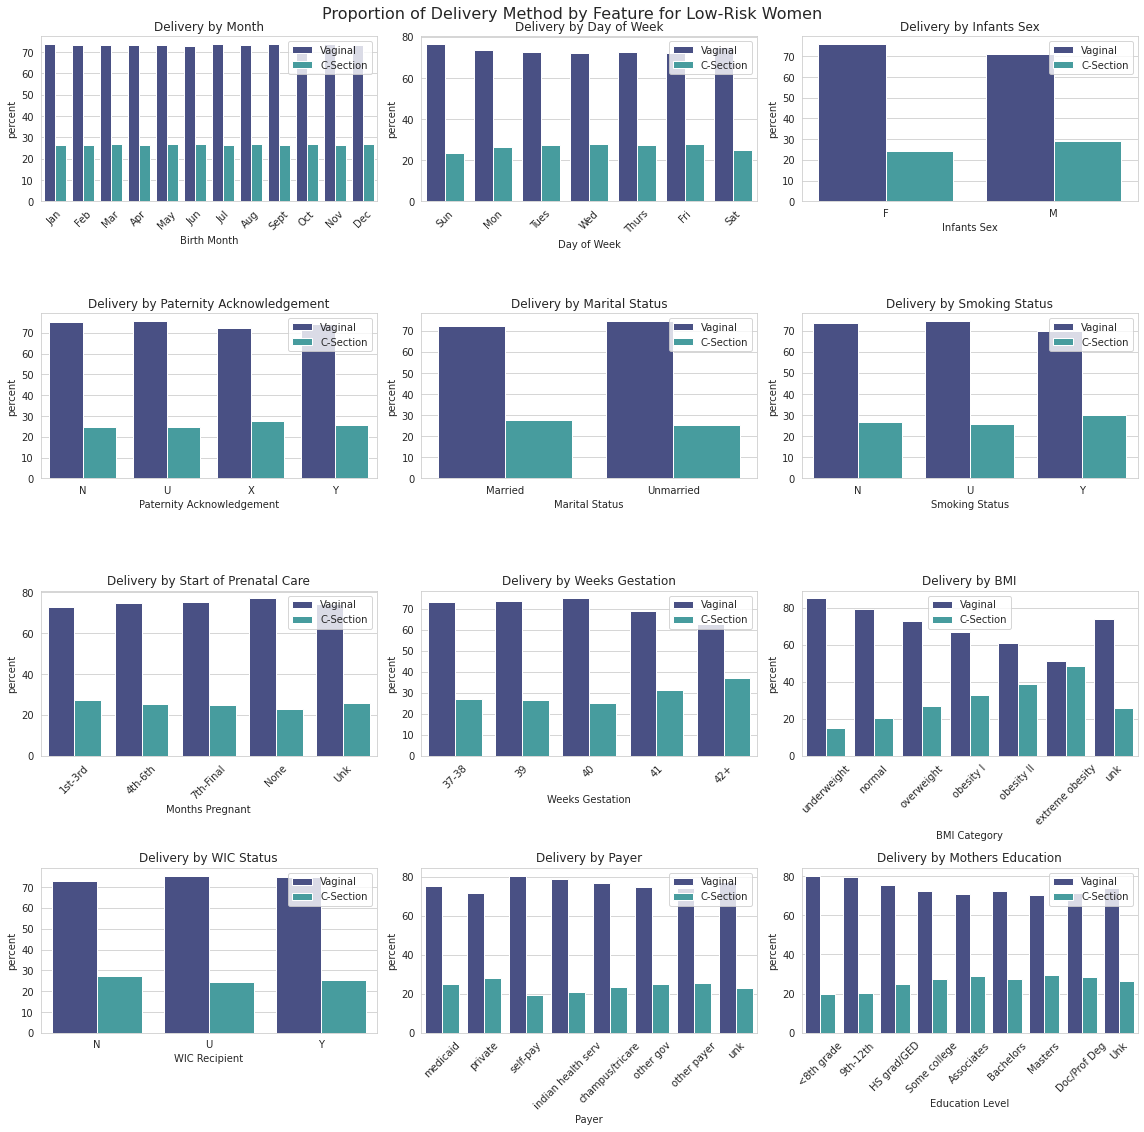

In [ ]:
#set up subplots for delivery comparisons
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
fig.suptitle('Proportion of Delivery Method by Feature for Low-Risk Women', fontsize=16)
sns.set_style('whitegrid')

#create labels for delivery method
delivery_label = ['Vaginal', 'C-Section']

#create labels for birth day
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
day = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']

#create labels for dmar
marital = ['Married', 'Unmarried']

#create labels for education
education = ['<8th grade', '9th-12th', 'HS grad/GED', 'Some college', 'Associates', 'Bachelors', 'Masters', 'Doc/Prof Deg', 'Unk']

#create labels for prenatal care
prenatal = ['1st-3rd', '4th-6th', '7th-Final', 'None', 'Unk']

#create labels for BMI
bmi_labels = ['underweight', 'normal', 'overweight', 'obesity I', 'obesity II', 'extreme obesity', 'unk']

#create labels for payment
payer = ['medicaid', 'private', 'self-pay', 'indian health serv', 'champus/tricare', 'other gov', 'other payer', 'unk']

#create labels for combined gestation recode
gestation = ['37-38', '39', '40', '41', '42+']

#1 create barplot of month (0, 0)
sns.barplot(data=month_df, x='dob_mm', y='percent', hue='dmeth_rec', ax=axes[0, 0],  palette='mako')
axes[0, 0].set_xticklabels(month, rotation=45)
handles1, labels1 = axes[0,0].get_legend_handles_labels()
axes[0, 0].legend(handles1, delivery_label)
axes[0, 0].set_xlabel('Birth Month')
axes[0, 0].set_title('Delivery by Month')

#2 create bar plot of day (0, 1)
sns.barplot(data=day_df, x='dob_wk', y='percent', hue='dmeth_rec', ax=axes[0, 1], palette='mako')
axes[0, 1].set_xticklabels(day, rotation=45)
handles2, labels2 = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(handles2, delivery_label)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_title('Delivery by Day of Week')

#3 create bar plot of sex (0, 2) sex_df, sex
sns.barplot(data=sex_df, x='sex', y='percent', hue='dmeth_rec', ax=axes[0, 2], palette='mako')
handles3, labels3 = axes[0, 2].get_legend_handles_labels()
axes[0, 2].legend(handles3, delivery_label)
axes[0, 2].set_xlabel('Infants Sex')
axes[0, 2].set_title('Delivery by Infants Sex')

#4 create barplot of paternity acknowledgement (1, 0) pat_df, mar_p
sns.barplot(data=pat_df, x='mar_p', y='percent', hue='dmeth_rec', ax=axes[1, 0], palette='mako')
handles4, labels4 = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(handles4, delivery_label)
axes[1, 0].set_xlabel('Paternity Acknowledgement')
axes[1, 0].set_title('Delivery by Paternity Acknowledgement')

#5 create barplot of marital status (1, 1) marital_df, marital, dmar
sns.barplot(data = marital_df, x='dmar', y='percent', hue='dmeth_rec', ax=axes[1, 1], palette='mako')
axes[1, 1].set_xticklabels(marital)
handles5, labels5 = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(handles5, delivery_label)
axes[1, 1].set_xlabel('Marital Status')
axes[1, 1].set_title('Delivery by Marital Status')

#6 create barplot of smoking (1, 2) smoking_df, cig_rec
sns.barplot(data=smoking_df, x='cig_rec', y='percent', hue='dmeth_rec', ax=axes[1, 2], palette='mako')
handles6, labels6 = axes[1, 2].get_legend_handles_labels()
axes[1, 2].legend(handles6, delivery_label)
axes[1, 2].set_xlabel('Smoking Status')
axes[1, 2].set_title('Delivery by Smoking Status')

#7 create barplot of prenatal care (2, 0) prenatal_df, prenatal, precare5
sns.barplot(data=prenatal_df, x='precare5', y='percent', hue='dmeth_rec', ax=axes[2,0], palette='mako')
axes[2, 0].set_xticklabels(prenatal, rotation=45)
handles7, labels7 = axes[2, 0].get_legend_handles_labels()
axes[2, 0].legend(handles7, delivery_label)
axes[2, 0].set_xlabel('Months Pregnant')
axes[2, 0].set_title('Delivery by Start of Prenatal Care')

#8 create barplot of weeks gestation (2, 1) obs_df, gestation, oegest_r10
sns.barplot(data=obs_df, x='oegest_r10', y='percent', hue='dmeth_rec', ax=axes[2, 1], palette='mako')
axes[2, 1].set_xticklabels(gestation, rotation=45)
handles8, labels8 = axes[2, 1].get_legend_handles_labels()
axes[2, 1].legend(handles8, delivery_label)
axes[2, 1].set_xlabel('Weeks Gestation')
axes[2, 1].set_title('Delivery by Weeks Gestation')

#9 create plot of bmi (2, 2) bmi_df, bmi_labels, bmi_r
sns.barplot(data=bmi_df, x='bmi_r', y='percent', hue='dmeth_rec', ax=axes[2, 2], palette='mako')
axes[2, 2].set_xticklabels(bmi_labels, rotation=45)
handles9, labels9 = axes[2, 2].get_legend_handles_labels()
axes[2, 2].legend(handles9, delivery_label)
axes[2, 2].set_xlabel('BMI Category')
axes[2, 2].set_title('Delivery by BMI')

#10 create plot of wic status (3, 0) wic_df, wic
sns.barplot(data=wic_df, x='wic', y='percent', hue='dmeth_rec', ax=axes[3, 0], palette='mako')
handles10, labels10 = axes[3, 0].get_legend_handles_labels()
axes[3, 0].legend(handles10, delivery_label)
axes[3, 0].set_xlabel('WIC Recipient')
axes[3, 0].set_title('Delivery by WIC Status')

#11 create plot of payer (3, 1) payer_df, payer, pay
sns.barplot(data=payer_df, x='pay', y='percent', hue='dmeth_rec', ax=axes[3, 1], palette='mako')
axes[3, 1].set_xticklabels(payer, rotation=45)
handles11, labels11 = axes[3, 1].get_legend_handles_labels()
axes[3, 1].legend(handles11, delivery_label)
axes[3, 1].set_xlabel('Payer')
axes[3, 1].set_title('Delivery by Payer')

#12 create plot of education (3, 2) education_df, education, meduc
sns.barplot(data=education_df, x='meduc', y='percent', hue='dmeth_rec', ax=axes[3, 2], palette='mako')
axes[3, 2].set_xticklabels(education, rotation=45)
handles12, labels12 = axes[3, 2].get_legend_handles_labels()
axes[3, 2].legend(handles12, delivery_label)
axes[3, 2].set_xlabel('Education Level')
axes[3, 2].set_title('Delivery by Mothers Education')

#display plots
plt.tight_layout()
plt.show()

## Comparing Various Maternal Risk Factors on Proportion of C-Section Deliveries

In [ ]:
#create df of pre-pregnancy diabetes
pdiab_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_pdiab').count().toPandas()
pdiab_df.sort_values(by='rf_pdiab', inplace=True, ascending=True)

#create df of gestational diabetes
gdiab_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_gdiab').count().toPandas()
gdiab_df.sort_values(by='rf_gdiab', inplace=True, ascending=True)

#create df of pre-pregnancy hypertension
phype_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_phype').count().toPandas()
phype_df.sort_values(by='rf_phype', inplace=True, ascending=True)

#create df of gestational hypertension
ghype_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_ghype').count().toPandas()
ghype_df.sort_values(by='rf_ghype', inplace=True, ascending=True)

#create df of hypertension eclampsia
ehype_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_ehype').count().toPandas()
ehype_df.sort_values(by='rf_ehype', inplace=True, ascending=True)

#create df of infertility treatment
inftr_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_inftr').count().toPandas()
inftr_df.sort_values(by='rf_inftr', inplace=True, ascending=True)

#create df of fertility enhancing drugs
fedrg_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_fedrg').count().toPandas()
fedrg_df.sort_values(by='rf_fedrg', inplace=True, ascending=True)

#create df of assisted reproductive technology
artec_df = low_risk_df.where(col('no_risks') != 1).groupBy('dmeth_rec', 'rf_artec').count().toPandas()
artec_df.sort_values(by='rf_artec', inplace=True, ascending=True)

#create df of no risk factors
norisk_df = low_risk_df.groupBy('dmeth_rec', 'no_risks').count().toPandas()
norisk_df.sort_values(by='no_risks', inplace=True, ascending=True)

In [ ]:
#add proportion of delivery method to pdiab, rf_pdiab
pdiab_df['prop'] = pdiab_df['count'] / pdiab_df.groupby('rf_pdiab')['count'].transform('sum')
pdiab_df['percent'] = (pdiab_df['prop'] * 100).round(1)

#gdiab, rf_gdiab
gdiab_df['prop'] = gdiab_df['count'] / gdiab_df.groupby('rf_gdiab')['count'].transform('sum')
gdiab_df['percent'] = (gdiab_df['prop'] * 100).round(1)

#phype, rf_phype
phype_df['prop'] = phype_df['count'] / phype_df.groupby('rf_phype')['count'].transform('sum')
phype_df['percent'] = (phype_df['prop'] * 100).round(1)

#ghype, rf_ghype
ghype_df['prop'] = ghype_df['count'] / ghype_df.groupby('rf_ghype')['count'].transform('sum')
ghype_df['percent'] = (ghype_df['prop'] * 100).round(1)

#ehype, rf_ehype
ehype_df['prop'] = ehype_df['count'] / ehype_df.groupby('rf_ehype')['count'].transform('sum')
ehype_df['percent'] = (ehype_df['prop'] * 100).round(1)

#rf_inftr
inftr_df['prop'] = inftr_df['count'] / inftr_df.groupby('rf_inftr')['count'].transform('sum')
inftr_df['percent'] = (inftr_df['prop'] * 100).round(1)

#rf_fedrg
fedrg_df['prop'] = fedrg_df['count'] / fedrg_df.groupby('rf_fedrg')['count'].transform('sum')
fedrg_df['percent'] = (fedrg_df['prop'] * 100).round(1)

#rf_artec
artec_df['prop'] = artec_df['count'] / artec_df.groupby('rf_artec')['count'].transform('sum')
artec_df['percent'] = (artec_df['prop'] * 100).round(1)

#norisk_df, no_risks
norisk_df['prop'] = norisk_df['count'] / norisk_df.groupby('no_risks')['count'].transform('sum')
norisk_df['percent'] = (norisk_df['prop'] * 100).round(1)

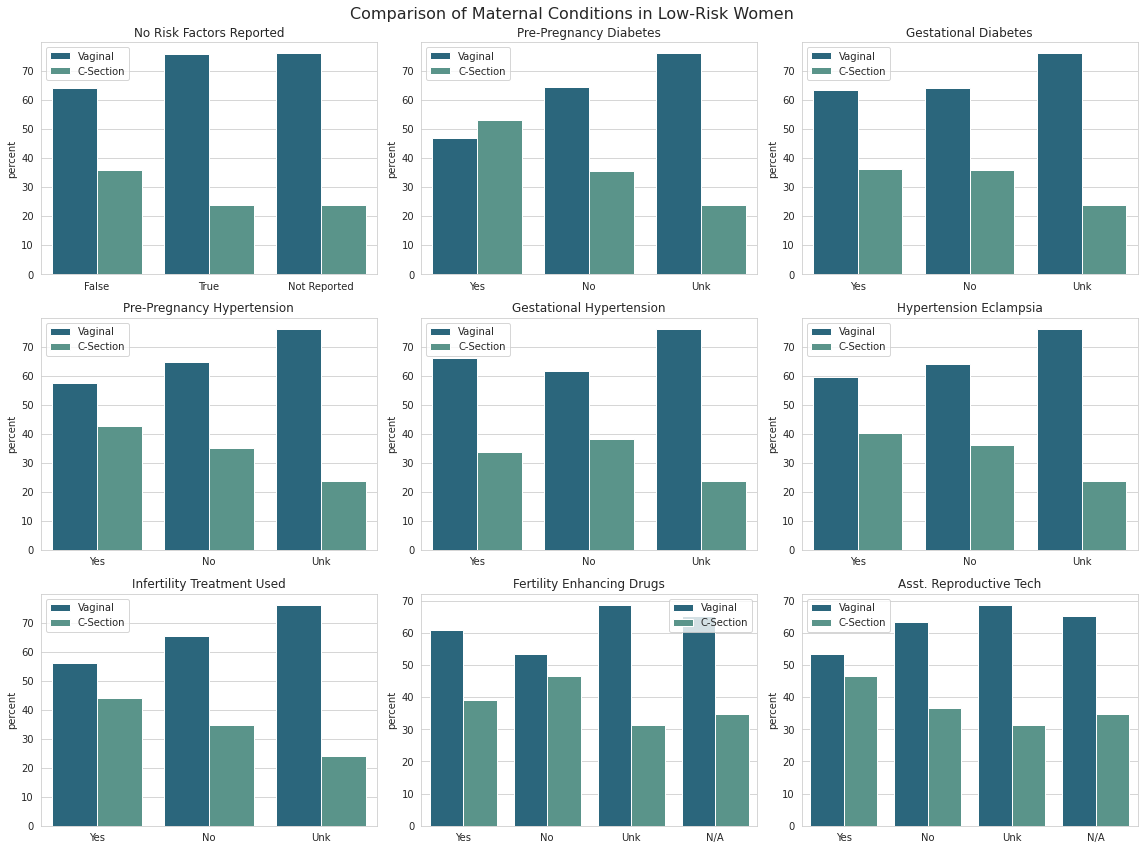

In [ ]:
#set up subplots for delivery comparisons
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Comparison of Maternal Conditions in Low-Risk Women', fontsize=16)
sns.set_style('whitegrid')

#create labels for delivery method
delivery_label = ['Vaginal', 'C-Section']

#create labels for no risk factors reported
norf = ['False', 'True', 'Not Reported']

#create ordering list
orderx = ['Y', 'N', 'U', 'X']
order = ['Y', 'N', 'U']

#1 create barplot of no risk factors (0, 0)
sns.barplot(data=norisk_df, x='no_risks', y='percent', hue='dmeth_rec', ax=axes[0, 0],  palette='crest_r')
axes[0, 0].set_xticklabels(norf)
handles1, labels1 = axes[0,0].get_legend_handles_labels()
axes[0, 0].legend(handles1, delivery_label)
axes[0, 0].set_title('No Risk Factors Reported')
axes[0, 0].set_xlabel('')

#2 create bar plot of prepregnancy diabetes (0, 1) pdiab_df, rf_pdiab
sns.barplot(data=pdiab_df, x='rf_pdiab', y='percent', hue='dmeth_rec', ax=axes[0, 1], palette='crest_r', order=order)
axes[0, 1].set_xticklabels(['Yes', 'No', 'Unk'])
handles2, labels2 = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(handles2, delivery_label)
axes[0, 1].set_xlabel('')
axes[0, 1].set_title('Pre-Pregnancy Diabetes')

#3 create bar plot of gestational diabetes (0, 2) gdiab_df, rf_gdiab
sns.barplot(data=gdiab_df, x='rf_gdiab', y='percent', hue='dmeth_rec', ax=axes[0, 2], palette='crest_r', order=order)
axes[0, 2].set_xticklabels(['Yes', 'No', 'Unk'])
handles3, labels3 = axes[0, 2].get_legend_handles_labels()
axes[0, 2].legend(handles3, delivery_label)
axes[0, 2].set_title('Gestational Diabetes')
axes[0, 2].set_xlabel('')

#4 create barplot of prepregnancy hypertension (1, 0) phype_df, rf_phype
sns.barplot(data=phype_df, x='rf_phype', y='percent', hue='dmeth_rec', ax=axes[1, 0], palette='crest_r', order=order)
axes[1, 0].set_xticklabels(['Yes', 'No', 'Unk'])
handles4, labels4 = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(handles4, delivery_label)
axes[1, 0].set_title('Pre-Pregnancy Hypertension')
axes[1, 0].set_xlabel('')

#5 create barplot of gestational hypertension (1, 1) ghype_df, rf_ghype
sns.barplot(data = ghype_df, x='rf_ghype', y='percent', hue='dmeth_rec', ax=axes[1, 1], palette='crest_r', order=order)
axes[1, 1].set_xticklabels(['Yes', 'No', 'Unk'])
handles5, labels5 = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(handles5, delivery_label)
axes[1, 1].set_title('Gestational Hypertension')
axes[1, 1].set_xlabel('')

#6 create barplot of hypertension eclampsia (1, 2) ehype_df, rf_ehype
sns.barplot(data=ehype_df, x='rf_ehype', y='percent', hue='dmeth_rec', ax=axes[1, 2], palette='crest_r', order=order)
axes[1, 2].set_xticklabels(['Yes', 'No', 'Unk'])
handles6, labels6 = axes[1, 2].get_legend_handles_labels()
axes[1, 2].legend(handles6, delivery_label)
axes[1, 2].set_title('Hypertension Eclampsia')
axes[1, 2].set_xlabel('')

#7 create plot of infertility treatment (3, 0) inftr_df, rf_inftr
sns.barplot(data=inftr_df, x='rf_inftr', y='percent', hue='dmeth_rec', ax=axes[2, 0], palette='crest_r', order=order)
axes[2, 0].set_xticklabels(['Yes', 'No', 'Unk'])
handles7, labels7 = axes[2, 0].get_legend_handles_labels()
axes[2, 0].legend(handles7, delivery_label)
axes[2, 0].set_title('Infertility Treatment Used')
axes[2, 0].set_xlabel('')

#8 create plot of fertility enhancing drugs (3, 1) fedrg_df, rf_fedrg
sns.barplot(data=fedrg_df, x='rf_fedrg', y='percent', hue='dmeth_rec', ax=axes[2, 1], palette='crest_r', order=orderx)
axes[2, 1].set_xticklabels(['Yes', 'No', 'Unk', 'N/A'])
handles8, labels8 = axes[2, 1].get_legend_handles_labels()
axes[2, 1].legend(handles8, delivery_label)
axes[2, 1].set_title('Fertility Enhancing Drugs')
axes[2, 1].set_xlabel('')

#9 create plot of Asst. Repr Tech (3, 2) artec_df, rf_artec
sns.barplot(data=artec_df, x='rf_artec', y='percent', hue='dmeth_rec', ax=axes[2, 2], palette='crest_r', order=orderx)
axes[2, 2].set_xticklabels(['Yes', 'No', 'Unk', 'N/A'])
handles9, labels9 = axes[2, 2].get_legend_handles_labels()
axes[2, 2].legend(handles9, delivery_label)
axes[2, 2].set_xlabel('')
axes[2, 2].set_title('Asst. Reproductive Tech')

#display plots
plt.tight_layout()
plt.show()

## Comparing Infections reported
no_infec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc

In [ ]:
#create df of maternal infections
noinfec_df = low_risk_df.groupby('dmeth_rec', 'no_infec').count().toPandas()
noinfec_df.sort_values(by='no_infec', inplace=True, ascending=True)

#create df of gonorrhea
gon_df = low_risk_df.where(col('no_infec') != 1).groupby('dmeth_rec', 'ip_gon').count().toPandas()
gon_df.sort_values(by='ip_gon', inplace=True)

#create df of syphilis
syph_df = low_risk_df.where(col('no_infec') != 1).groupby('dmeth_rec', 'ip_syph').count().toPandas()
syph_df.sort_values(by='ip_syph', inplace=True)

#create df of chlamydia
chlam_df = low_risk_df.where(col('no_infec') != 1).groupby('dmeth_rec', 'ip_chlam').count().toPandas()
chlam_df.sort_values(by='ip_chlam', inplace=True)

#create df of hep b
hepb_df = low_risk_df.where(col('no_infec') != 1).groupby('dmeth_rec', 'ip_hepb').count().toPandas()
hepb_df.sort_values(by='ip_hepb', inplace=True)

#create df of hep c
hepc_df = low_risk_df.where(col('no_infec') != 1).groupby('dmeth_rec', 'ip_hepc').count().toPandas()
hepc_df.sort_values(by='ip_hepc', inplace=True)

In [ ]:
#add proportion of delivery method to maternal infections
noinfec_df['prop'] = noinfec_df['count'] / noinfec_df.groupby('no_infec')['count'].transform('sum')
noinfec_df['percent'] = (noinfec_df['prop'] * 100).round(1)

#add proportion of delivery method to gonorrhea
gon_df['prop'] = gon_df['count'] / gon_df.groupby('ip_gon')['count'].transform('sum')
gon_df['percent'] = (gon_df['prop'] * 100).round(1)

#add proportion of delivery method to syphilis
syph_df['prop'] = syph_df['count'] / syph_df.groupby('ip_syph')['count'].transform('sum')
syph_df['percent'] = (syph_df['prop'] * 100).round(1)

#add proportion of delivery method to chlamydia
chlam_df['prop'] = chlam_df['count'] / chlam_df.groupby('ip_chlam')['count'].transform('sum')
chlam_df['percent'] = (chlam_df['prop'] * 100).round(1)

#add proportion of delivery method to hep b
hepb_df['prop'] = hepb_df['count'] / hepb_df.groupby('ip_hepb')['count'].transform('sum')
hepb_df['percent'] = (hepb_df['prop'] * 100).round(1)

#add proportion of delivery method to hep c
hepc_df['prop'] = hepc_df['count'] / hepc_df.groupby('ip_hepc')['count'].transform('sum')
hepc_df['percent'] = (hepc_df['prop'] * 100).round(1)

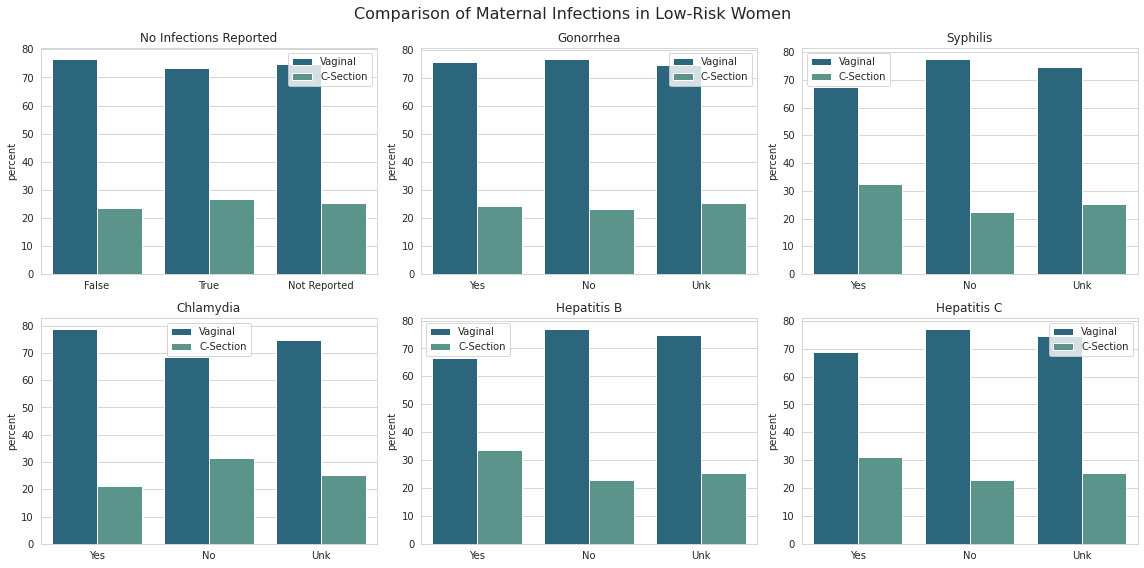

In [ ]:
#set up subplots for delivery comparisons
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('Comparison of Maternal Infections in Low-Risk Women', fontsize=16)
sns.set_style('whitegrid')

#create labels for delivery method
delivery_label = ['Vaginal', 'C-Section']

#create labels for no infections reported
noinf = ['False', 'True', 'Not Reported']

#create ordering list
orderx = ['Y', 'N', 'U', 'X']
order = ['Y', 'N', 'U']

#1 create barplot of no infections (0, 0)
sns.barplot(data=noinfec_df, x='no_infec', y='percent', hue='dmeth_rec', ax=axes[0, 0],  palette='crest_r')
axes[0, 0].set_xticklabels(noinf)
handles1, labels1 = axes[0,0].get_legend_handles_labels()
axes[0, 0].legend(handles1, delivery_label)
axes[0, 0].set_title('No Infections Reported')
axes[0, 0].set_xlabel('')

#2 create bar plot of gonorrhea (0, 1)
sns.barplot(data=gon_df, x='ip_gon', y='percent', hue='dmeth_rec', ax=axes[0, 1], palette='crest_r', order=order)
axes[0, 1].set_xticklabels(['Yes', 'No', 'Unk'])
handles2, labels2 = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(handles2, delivery_label)
axes[0, 1].set_xlabel('')
axes[0, 1].set_title('Gonorrhea')

#3 create bar plot of syphilis (0, 2)
sns.barplot(data=syph_df, x='ip_syph', y='percent', hue='dmeth_rec', ax=axes[0, 2], palette='crest_r', order=order)
axes[0, 2].set_xticklabels(['Yes', 'No', 'Unk'])
handles3, labels3 = axes[0, 2].get_legend_handles_labels()
axes[0, 2].legend(handles3, delivery_label)
axes[0, 2].set_title('Syphilis')
axes[0, 2].set_xlabel('')

#4 create barplot of chlamydia (1, 0)
sns.barplot(data=chlam_df, x='ip_chlam', y='percent', hue='dmeth_rec', ax=axes[1, 0], palette='crest_r', order=order)
axes[1, 0].set_xticklabels(['Yes', 'No', 'Unk'])
handles4, labels4 = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(handles4, delivery_label)
axes[1, 0].set_title('Chlamydia')
axes[1, 0].set_xlabel('')

#5 create barplot of hepatitis b (1, 1)
sns.barplot(data = hepb_df, x='ip_hepb', y='percent', hue='dmeth_rec', ax=axes[1, 1], palette='crest_r', order=order)
axes[1, 1].set_xticklabels(['Yes', 'No', 'Unk'])
handles5, labels5 = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(handles5, delivery_label)
axes[1, 1].set_title('Hepatitis B')
axes[1, 1].set_xlabel('')

#6 create barplot of hepatitis c (1, 2)
sns.barplot(data=hepc_df, x='ip_hepc', y='percent', hue='dmeth_rec', ax=axes[1, 2], palette='crest_r', order=order)
axes[1, 2].set_xticklabels(['Yes', 'No', 'Unk'])
handles6, labels6 = axes[1, 2].get_legend_handles_labels()
axes[1, 2].legend(handles6, delivery_label)
axes[1, 2].set_title('Hepatitis C')
axes[1, 2].set_xlabel('')

#display plots
plt.tight_layout()
plt.show()

## Correlations

In [ ]:
#identify categorical columns to explore correlation
categorical = ['dmeth_rec', 'dob_mm', 'dob_wk', 'bfacil3',

               #demographic variables
               'meduc', 'mager9', 'mrace15', 'mhisp_r', 'mracehisp', 'dmar', 'wic', 'pay', 'pay_rec',

               #maternal risk factors
               'cig_rec', 'no_risks', 'no_infec',

               #maternal care
               'oegest_r10', 'precare5', 'previs_rec', 'bmi_r', 'wtgain_rec',

               #newborn characteristics
               'sex', 'no_congen', 'bwtr4']

In [ ]:
#identify categorical columns to explore correlation
categorical2 = ['dmeth_rec', 'bfacil3',

               #demographic variables
               'meduc', 'mager9', 'mrace15', 'mhisp_r', 'dmar', 'wic', 'pay',

               #maternal risk factors
               'cig_rec', 'no_risks', 'no_infec',

               #maternal care
               'oegest_r10', 'precare5', 'bmi_r',

               #newborn characteristics
               'sex', 'no_congen', 'bwtr4']

In [ ]:
corr_df = low_risk_df.select(*categorical2).toPandas()

In [ ]:
def chi2_assoc(df, categorical_cols):
    chi2_results = []

    for var1, var2 in combinations(categorical_cols, 2):
        contingency = pd.crosstab(df[var1], df[var2])
        try:
            chi2, p, dof, ex = chi2_contingency(contingency)
            chi2_results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Chi2 Stat': chi2,
                'p-value': p,
                'Degrees of Freedom': dof
            })
        except ValueError:
            chi2_results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Chi2 Stat': np.nan,
                'p-value': np.nan,
                'Degrees of Freedom': np.nan
            })
    return pd.DataFrame(chi2_results)

In [ ]:
#create dataframe of the correlation info
chi2_df = chi2_assoc(corr_df, categorical2)

#create pivot table for chi2 statistic
chi2_pivot = chi2_df.pivot(index='Variable 1', columns='Variable 2', values='Chi2 Stat')

#mirror the matrix to be square
chi2_matrix = chi2_pivot.copy()
chi2_matrix = chi2_matrix.combine_first(chi2_matrix.T)

In [ ]:
print(chi2_matrix)

                  bfacil3         bmi_r         bwtr4       cig_rec  \
bfacil3               NaN   3783.643670    927.405334    201.116722   
bmi_r         3783.643670           NaN   1945.461502   6301.495133   
bwtr4          927.405334   1945.461502           NaN   1040.439005   
cig_rec        201.116722   6301.495133   1040.439005           NaN   
dmar          3306.467947   8417.725448   2179.352940  10913.507286   
dmeth_rec     6326.364338  38694.721072    309.527504    121.895701   
mager9         938.637171  20445.537771   1185.753375   1675.784603   
meduc         6841.242335  43044.468335   2271.007048  21253.635674   
mhisp_r       1884.335424  13848.148472    264.212457   8309.514227   
mrace15       1373.672405  27946.341376   6656.108898   2805.989167   
no_congen      428.689089    107.818045    744.506797    214.119860   
no_infec       932.841753    881.466268    283.558007   3088.664243   
no_risks      4357.445189  53687.091512   1670.447979    375.058574   
oegest

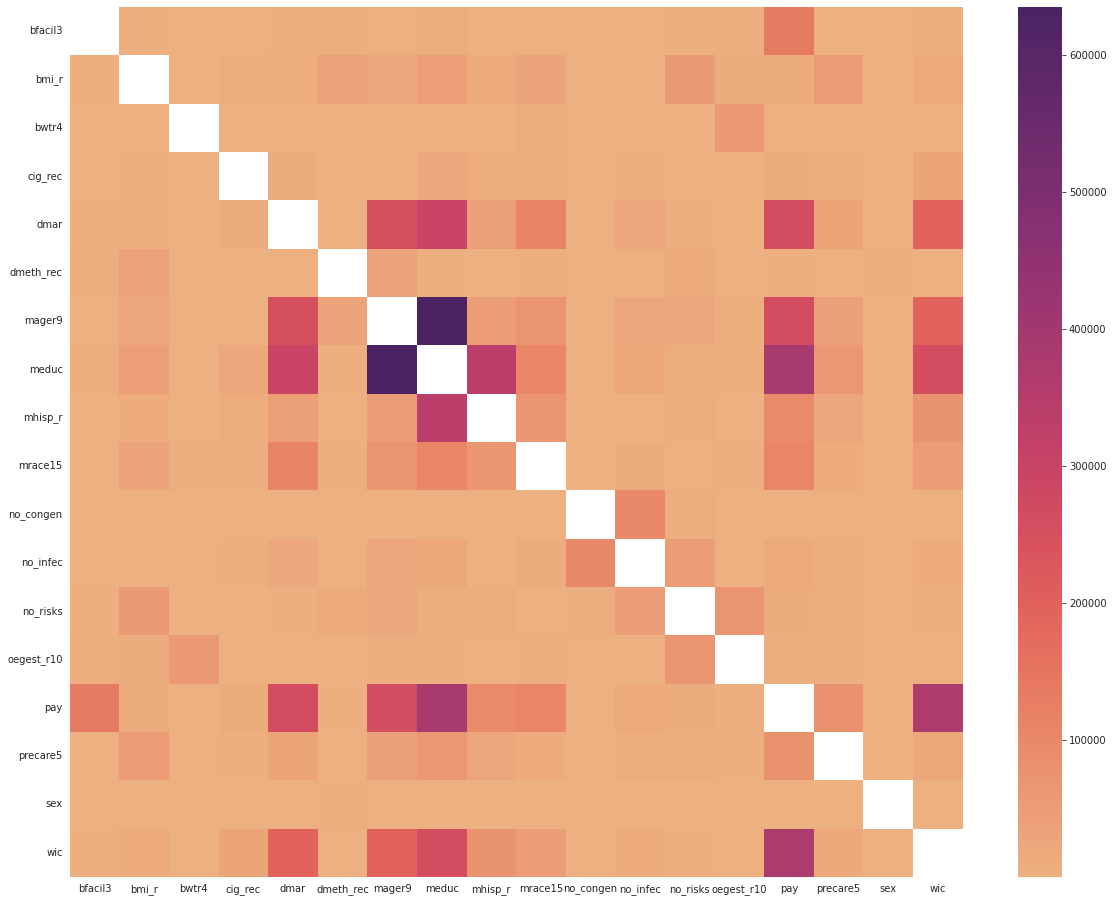

In [ ]:
plt.figure(figsize=(20, 16))
sns.heatmap(chi2_matrix, cmap='flare')
plt.show()

In [ ]:
#filter out 99
smoking = smoking[smoking['cig_0'] != 99]
smoking = smoking[smoking['cig_1'] != 99]
smoking = smoking[smoking['cig_2'] != 99]
smoking = smoking[smoking['cig_3'] != 99]
smoking = smoking[smoking['cig_3'] != 98]

In [ ]:
display(low_risk_df.filter(col('cig_0') > 40).count())

4066

In [ ]:
smoking.describe()

dmeth_rec 
 cig_0 
 cig_1 
 cig_2 
 cig_3 
 
 
 
 
 count 
 20658.000000 
 20658.000000 
 20658.000000 
 20658.000000 
 20658.000000 
 
 
 mean 
 1.299787 
 13.155339 
 9.931600 
 6.961371 
 6.020137 
 
 
 std 
 0.458176 
 11.563001 
 9.324725 
 8.215826 
 7.744597 
 
 
 min 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 25% 
 1.000000 
 5.000000 
 4.000000 
 1.000000 
 0.000000 
 
 
 50% 
 1.000000 
 10.000000 
 10.000000 
 5.000000 
 4.000000 
 
 
 75% 
 2.000000 
 20.000000 
 10.000000 
 10.000000 
 10.000000 
 
 
 max 
 2.000000 
 98.000000 
 98.000000 
 98.000000 
 90.000000

Out[175]: Text(0.5, 1.0, 'By Delivery Method')

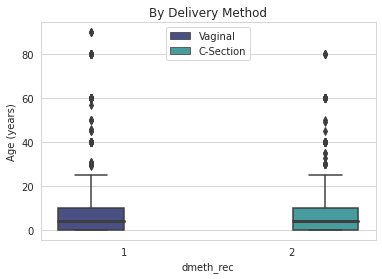

In [ ]:
#display boxplot of smoking by delivery method
a = sns.boxplot(x='dmeth_rec', y='cig_3', hue='dmeth_rec', data=smoking, palette='mako', medianprops={'linewidth' : 3})
handles2, labels2 = a.get_legend_handles_labels()
a.legend(handles2, delivery_label, loc='upper center')
a.set_ylabel('Age (years)')
a.set_title('By Delivery Method')

In [ ]:
#create list of variables that were continuous and NOT recodes or categorical
cont_var = ['dmeth_rec', 'mager', 'precare', 'cig_0', 'cig_1', 'bmi', 'wtgain',  'dbwt', 'oegest_comb']

#create df of continuous variables
cont_df = low_risk_df.select(*cont_var).toPandas()

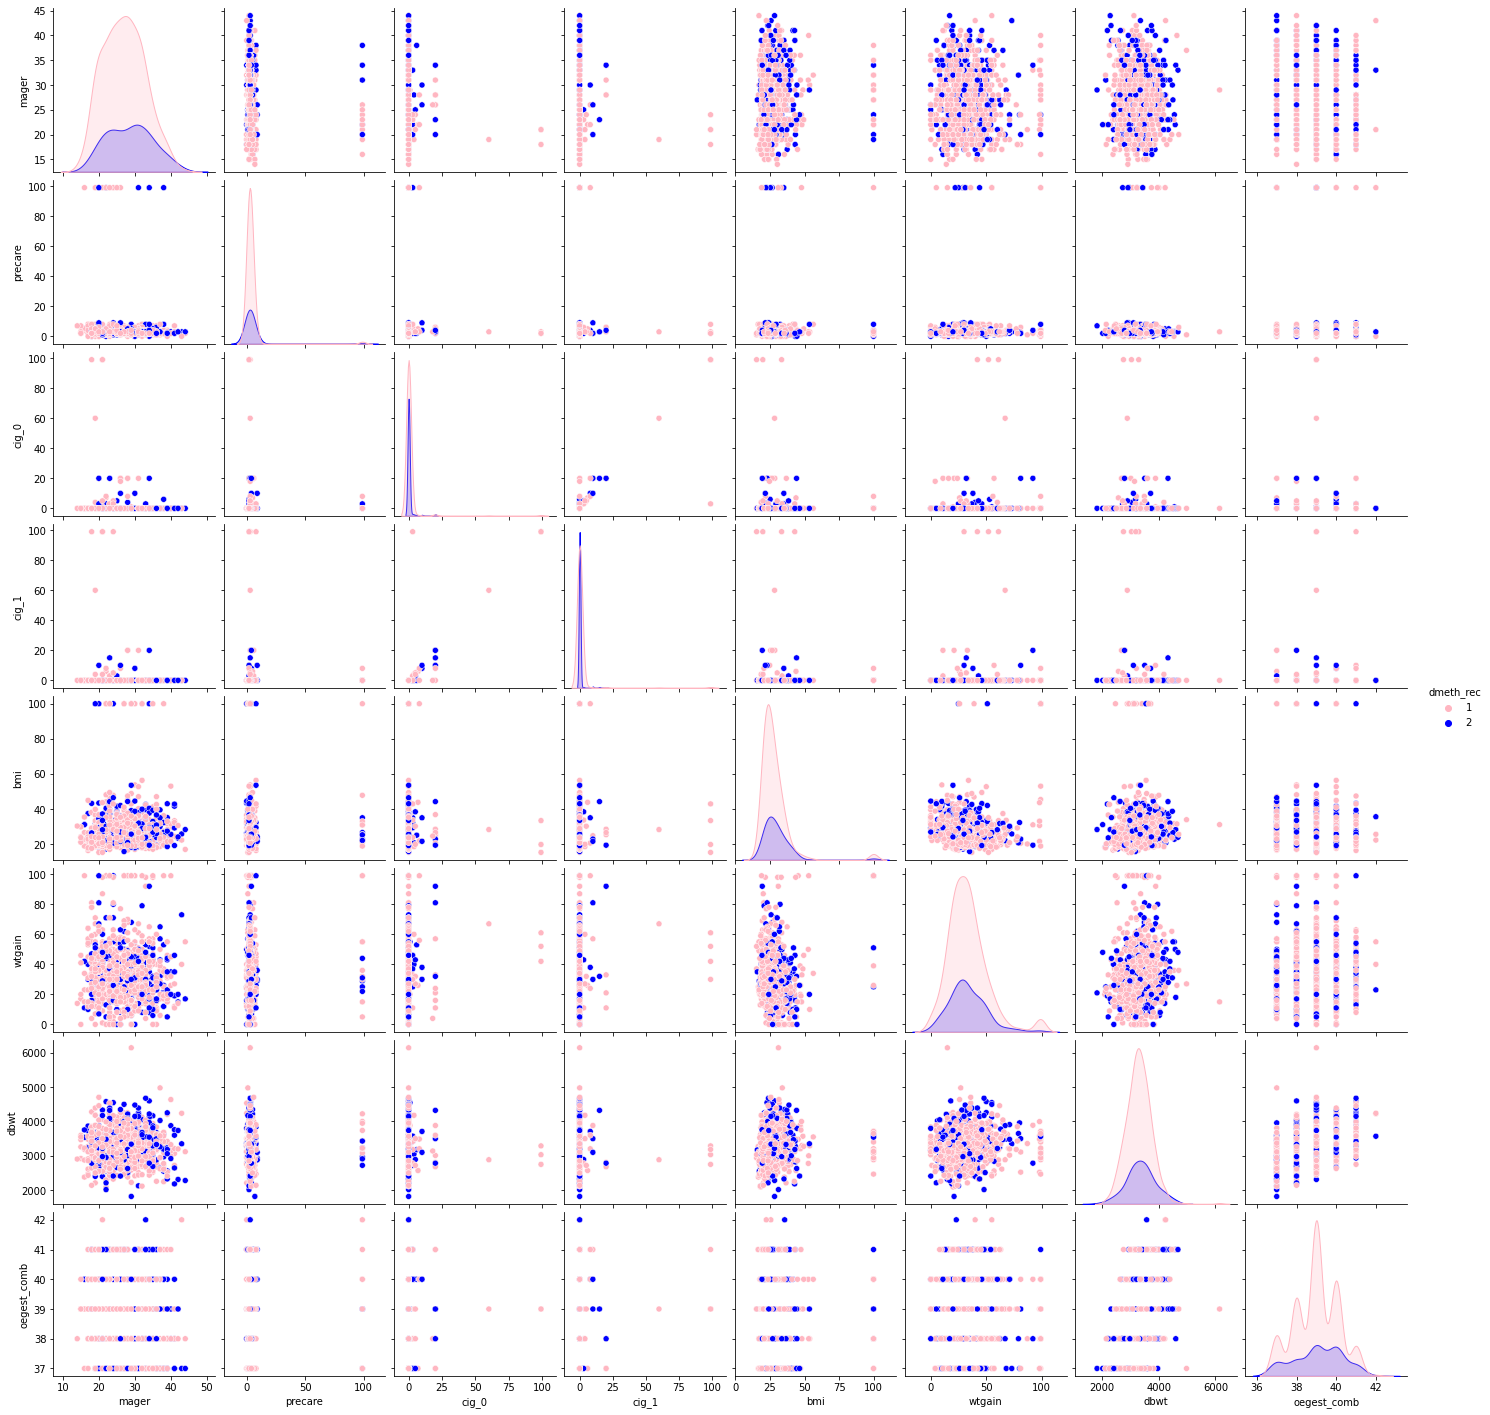

In [ ]:
#create pairplot of data
colors = ['lightpink', 'blue']
sns.pairplot(data=cont_df.sample(1000), palette=colors, hue='dmeth_rec')
plt.show()

In [ ]:
# second list of continuous variables
cont_var2 = ['dmeth_rec', 'dob_tt', 'mager', 'priorterm', 'precare', 'previs', 'cig_0', 'cig_1', 'm_ht_in', 'bmi', 'wtgain', 'dwgt_r', 'oegest_comb', 'dbwt']

#create df of continuous variables
cont_df2 = low_risk_df.select(*cont_var2).toPandas()

#update delivery label
cont_df2['delivery'] = cont_df2.apply(update_delivery, axis=1)

#drop previous delivery column
cont_df2.drop('dmeth_rec', axis=1, inplace=True)

In [ ]:
def get_stats(frame, fields):
    '''
    Obtains the summary statistics for each column in the dataframe, then prints the view to avoid creating multiple dataframes.

    Args:
    Frame - the specified dataframe to view
    Fields - a dictionary of fields to query, listed as field name (key) and title (value)

    Returns nothing, just prints the dataframe filter
    '''
    for k in fields:
        if k == 'delivery':
            continue
        else:
            print(f'Summary Statistics -- {fields[k]}') #print title of field

            #get summary statistics by delivery method, ensuring "count" isn't printed, as it would be redundant
            print(frame.groupby('delivery')[k].describe().drop('count', axis=1).round(2))
            print('')

    pass

In [ ]:
get_stats(cont_df2, cont_dict)

Summary Statistics -- Time of Birth
              mean     std  min    25%     50%     75%     max
delivery                                                      
c-section  1261.01  660.32  0.0  801.0  1301.0  1818.0  9999.0
vaginal    1242.54  679.13  0.0  658.0  1310.0  1815.0  9999.0

Summary Statistics -- Mothers Age
            mean   std   min   25%   50%   75%   max
delivery                                            
c-section  28.99  5.97  12.0  24.0  29.0  33.0  50.0
vaginal    26.77  5.68  12.0  22.0  27.0  31.0  50.0

Summary Statistics -- Prior Terminations
           mean   std  min  25%  50%  75%   max
delivery                                       
c-section  0.39  2.89  0.0  0.0  0.0  0.0  99.0
vaginal    0.34  3.08  0.0  0.0  0.0  0.0  99.0

Summary Statistics -- Month Prenatal Care Began
           mean    std  min  25%  50%  75%   max
delivery                                        
c-section  4.46  12.12  0.0  2.0  3.0  3.0  99.0
vaginal    4.59  12.43  0.0  2.0  3

In [ ]:
#drop rows where continuous values are unknown
cont_df2 = cont_df2[cont_df2['dob_tt'] != 9999]
cont_df2 = cont_df2[cont_df2['priorterm'] != 99]
cont_df2 = cont_df2[cont_df2['precare'] != 99]
cont_df2 = cont_df2[cont_df2['previs'] != 99]
cont_df2 = cont_df2[cont_df2['cig_0'] != 99]
cont_df2 = cont_df2[cont_df2['cig_1'] != 99]
cont_df2 = cont_df2[cont_df2['m_ht_in'] != 99]
cont_df2 = cont_df2[cont_df2['bmi'] != 99.9]
cont_df2 = cont_df2[cont_df2['wtgain'] != 99]
cont_df2 = cont_df2[cont_df2['dwgt_r'] != 999]
cont_df2 = cont_df2[cont_df2['oegest_comb'] != 99]
cont_df2 = cont_df2[cont_df2['dbwt'] != 9999]

In [ ]:
get_stats(cont_df2, cont_dict)

Summary Statistics -- Time of Birth
              mean     std  min    25%     50%     75%     max
delivery                                                      
c-section  1261.25  658.98  0.0  801.0  1301.0  1818.0  2359.0
vaginal    1243.28  676.77  0.0  700.0  1311.0  1815.0  2359.0

Summary Statistics -- Mothers Age
            mean   std   min   25%   50%   75%   max
delivery                                            
c-section  29.00  5.96  12.0  25.0  29.0  33.0  50.0
vaginal    26.79  5.67  12.0  22.0  27.0  31.0  50.0

Summary Statistics -- Prior Terminations
           mean   std  min  25%  50%  75%   max
delivery                                       
c-section  0.31  0.75  0.0  0.0  0.0  0.0  28.0
vaginal    0.24  0.64  0.0  0.0  0.0  0.0  18.0

Summary Statistics -- Month Prenatal Care Began
           mean   std  min  25%  50%  75%   max
delivery                                       
c-section  2.92  1.46  0.0  2.0  3.0  3.0  10.0
vaginal    2.97  1.52  0.0  2.0  3.0  

In [ ]:
#create dictionary based on continuous variable list
cont_dict = {'dob_tt':'Time of Birth',
             'mager':'Mothers Age',
             'priorterm':'Prior Terminations',
             'precare':'Month Prenatal Care Began',
             'previs':'Number of Prenatal Visits',
             'cig_0':'Number of Cigarettes Daily (before pregnancy)',
             'cig_1':'Number of Cigarettes Daily (first trimester)',
             'm_ht_in':'Mothers Height (in)',
             'bmi':'Mothers BMI',
             'wtgain':'Weight Gain',
             'dwgt_r':'Delivery Weight (of Mother)',
             'oegest_comb':'Obstetric Estimate (weeks)',
             'dbwt':'Birth Weight (grams, of newborn)'}

#iterate through dictionary

In [ ]:
cont_df2['delivery'] = cont_df2.apply(update_delivery, axis=1)
cont_df2.head()

dmeth_rec 
 dob_tt 
 mager 
 priorterm 
 precare 
 previs 
 cig_0 
 cig_1 
 m_ht_in 
 bmi 
 wtgain 
 dwgt_r 
 oegest_comb 
 dbwt 
 delivery 
 
 
 
 
 0 
 2 
 2112 
 35 
 1 
 2 
 9 
 0 
 0 
 60 
 22.500000 
 28 
 143 
 39 
 3765 
 c-section 
 
 
 1 
 2 
 1706 
 22 
 0 
 2 
 12 
 0 
 0 
 62 
 30.200001 
 31 
 196 
 39 
 3028 
 c-section 
 
 
 2 
 1 
 1841 
 29 
 0 
 3 
 13 
 0 
 0 
 66 
 23.900000 
 41 
 189 
 39 
 3405 
 vaginal 
 
 
 3 
 2 
 1307 
 31 
 0 
 5 
 8 
 0 
 0 
 64 
 30.000000 
 28 
 203 
 41 
 3005 
 c-section 
 
 
 4 
 1 
 1221 
 40 
 0 
 3 
 11 
 0 
 0 
 68 
 21.600000 
 29 
 171 
 38 
 3345 
 vaginal

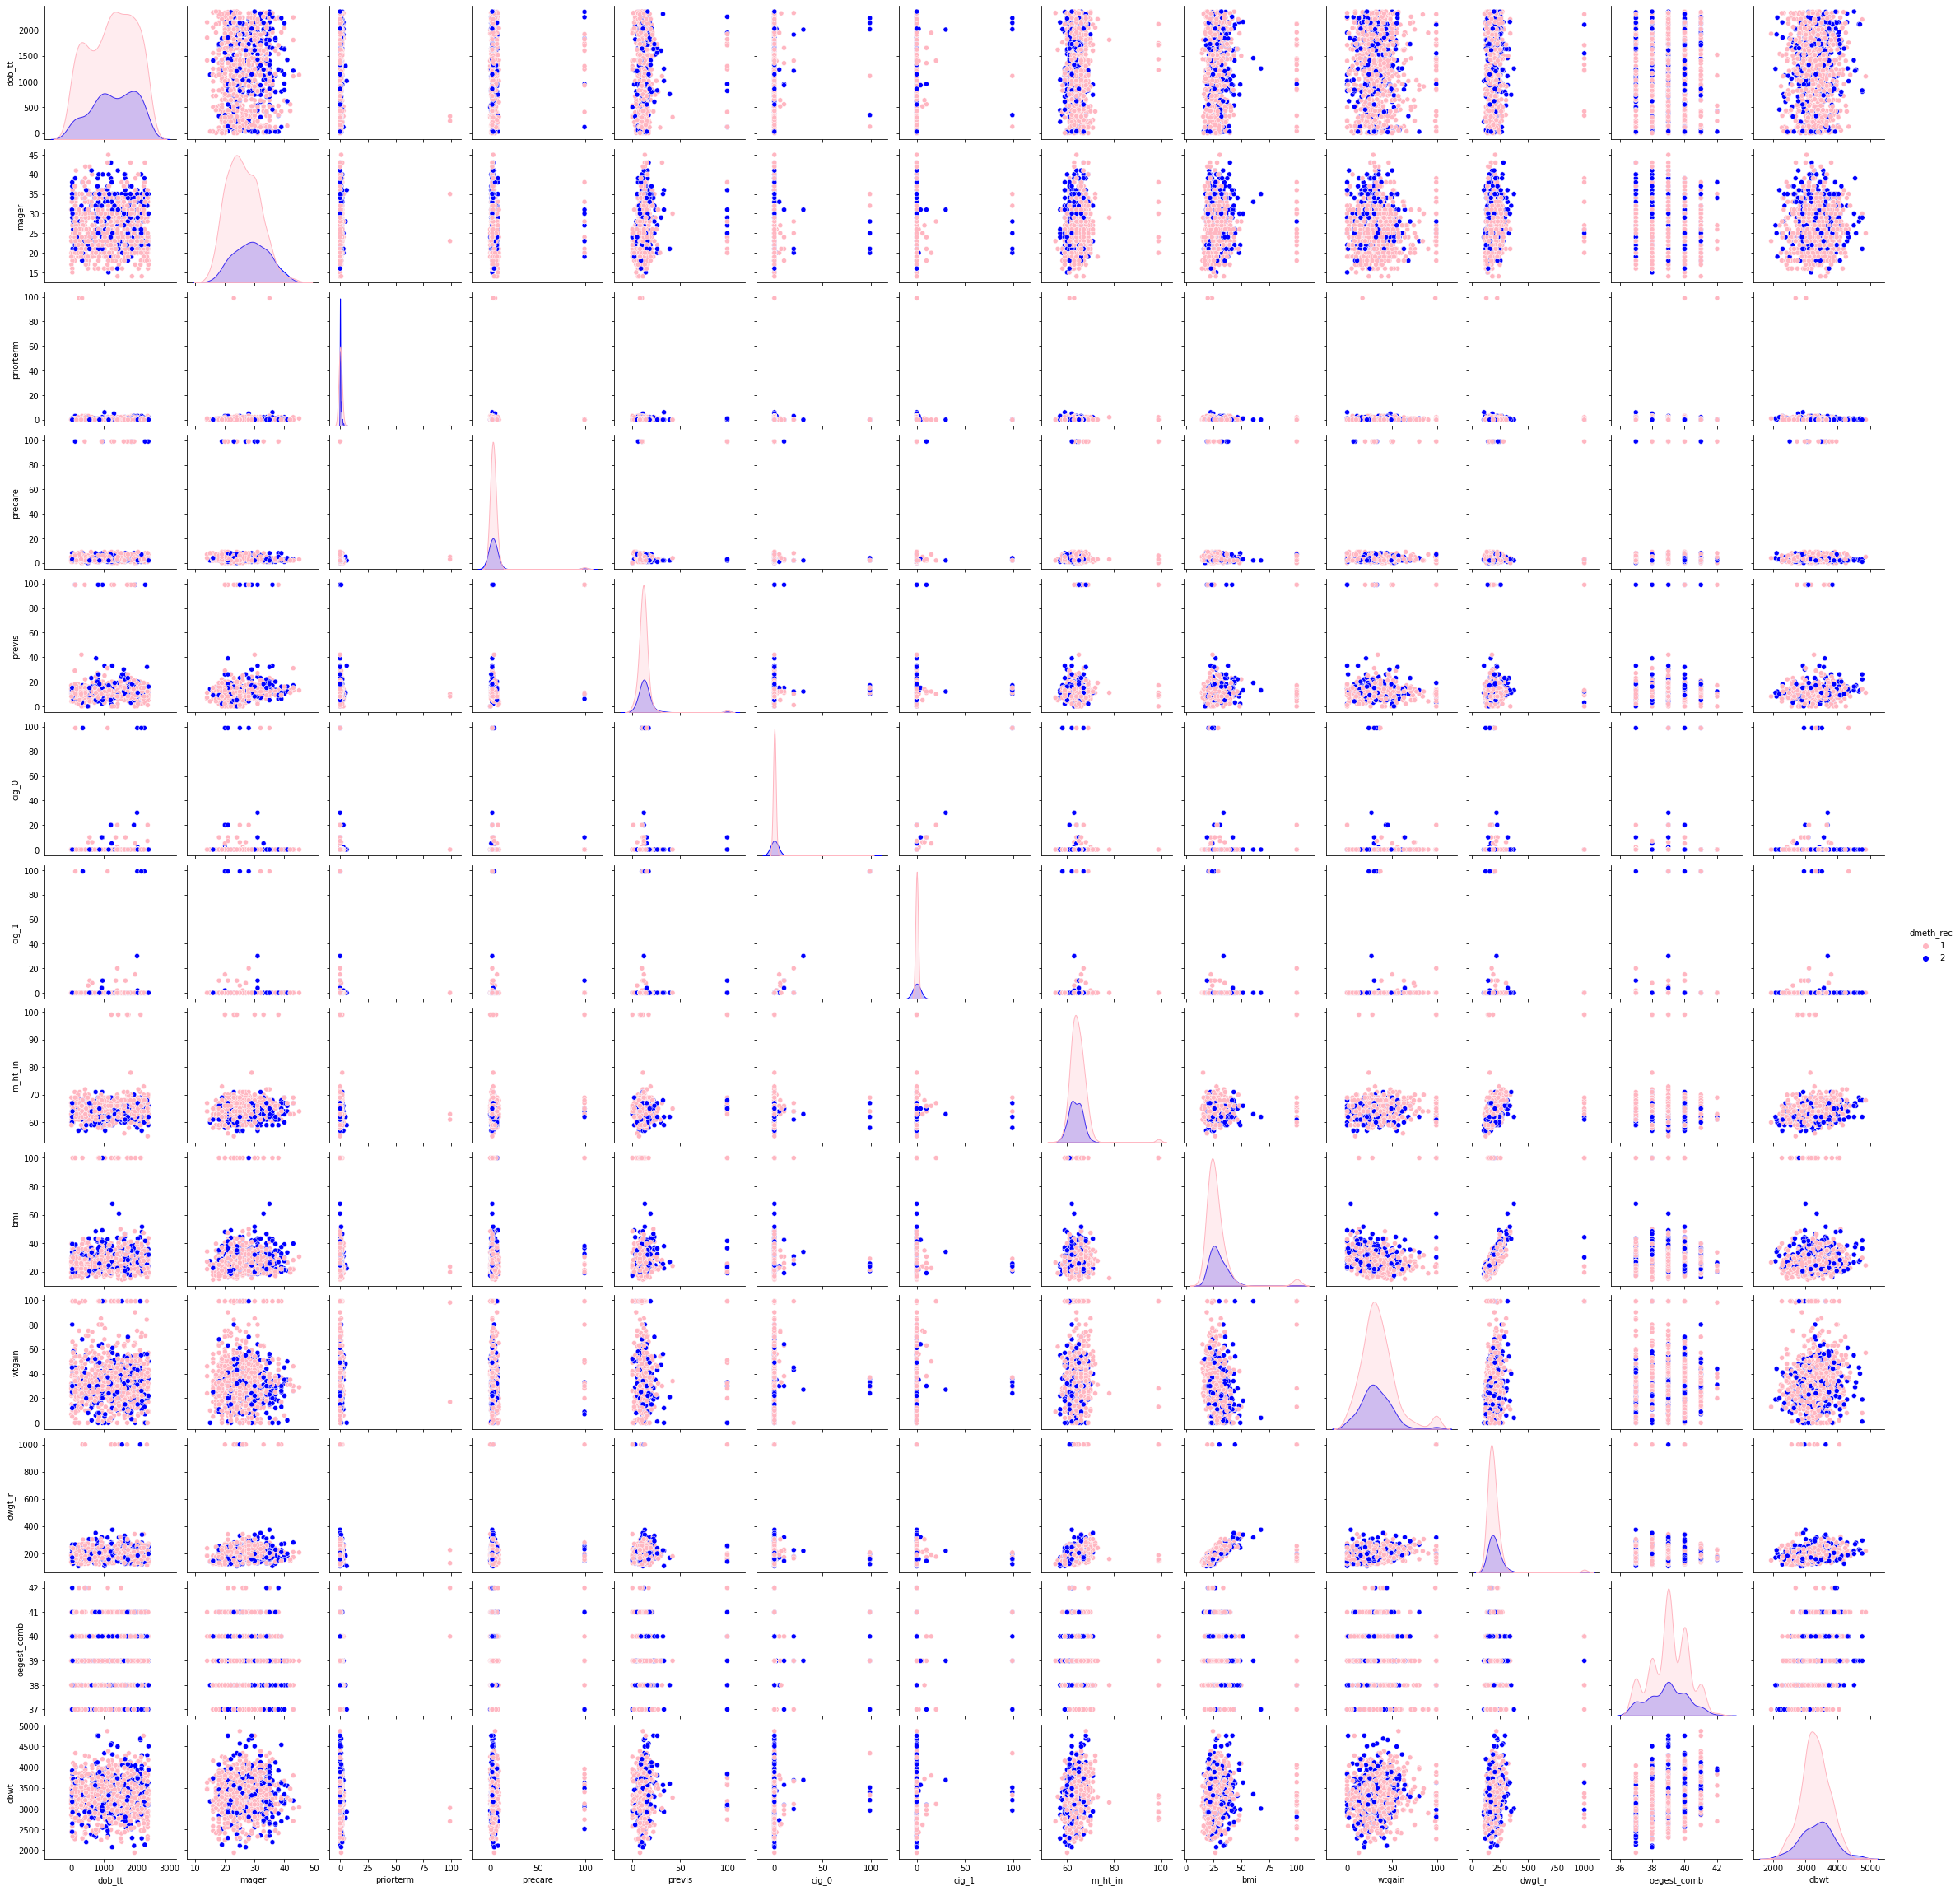

In [ ]:
#create pairplot of data
colors = ['lightpink', 'blue']
sns.pairplot(data=cont_df2.sample(1000), palette=colors, hue='delivery')
plt.show()

In [ ]:
#create list of ordinal variables
ordinal = ['dmeth_rec', 'dob_mm', 'dob_wk', 'mager9', 'meduc', 'precare5', 'previs_rec', 'cig0_r', 'cig1_r', 'cig2_r', 'cig3_r', 'bmi_r', 'wtgain_rec', 'oegest_r10', 'bwtr12', 'bwtr4']

#create df of ordinal variables
ordinal_df = low_risk_df.select(*ordinal).toPandas()

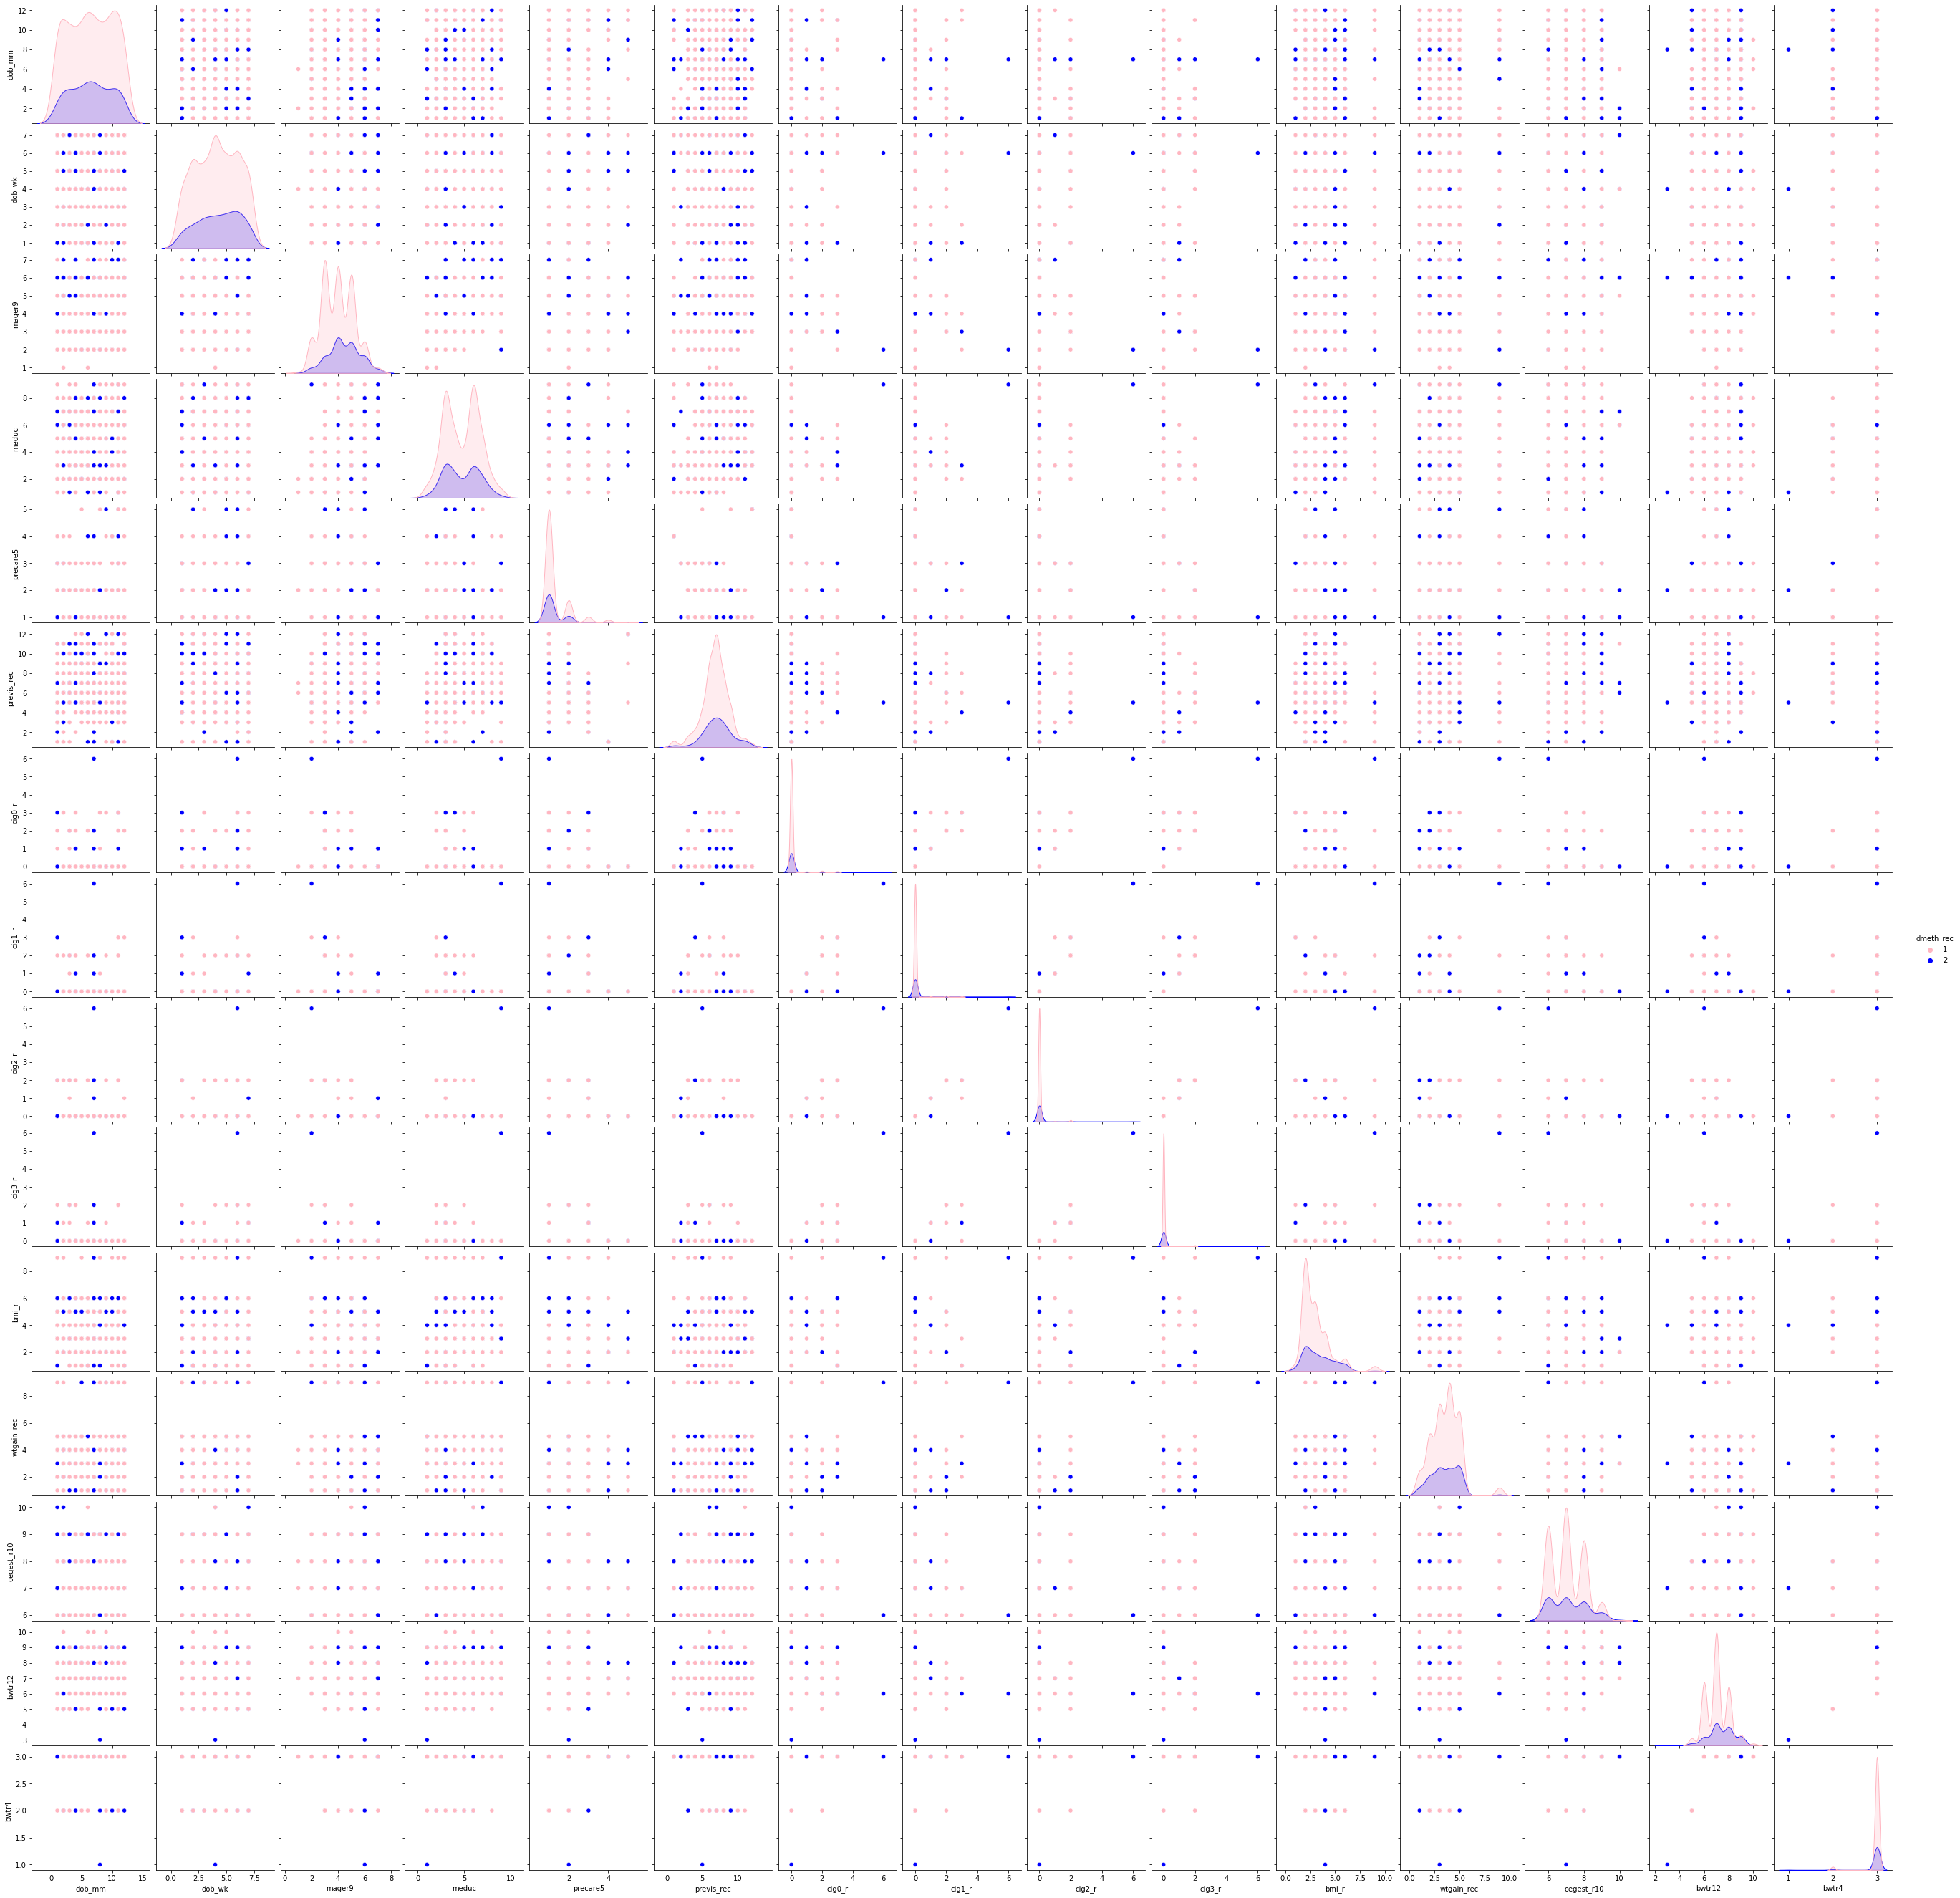

In [ ]:
#create pairplot of data
colors = ['lightpink', 'blue']
sns.pairplot(data=ordinal_df.sample(1000), palette=colors, hue='dmeth_rec')
plt.show()

In [ ]:
#examining father's information and delivery method
father = low_risk_df.select('dmeth_rec', 'fagecomb', 'fagerec11', 'frace6', 'frace15', 'fhispx', 'fhisp_r', 'fracehisp', 'feduc').toPandas()

#sns.pairplot(ces_data, hue='dmeth_rec', palette='viridis')

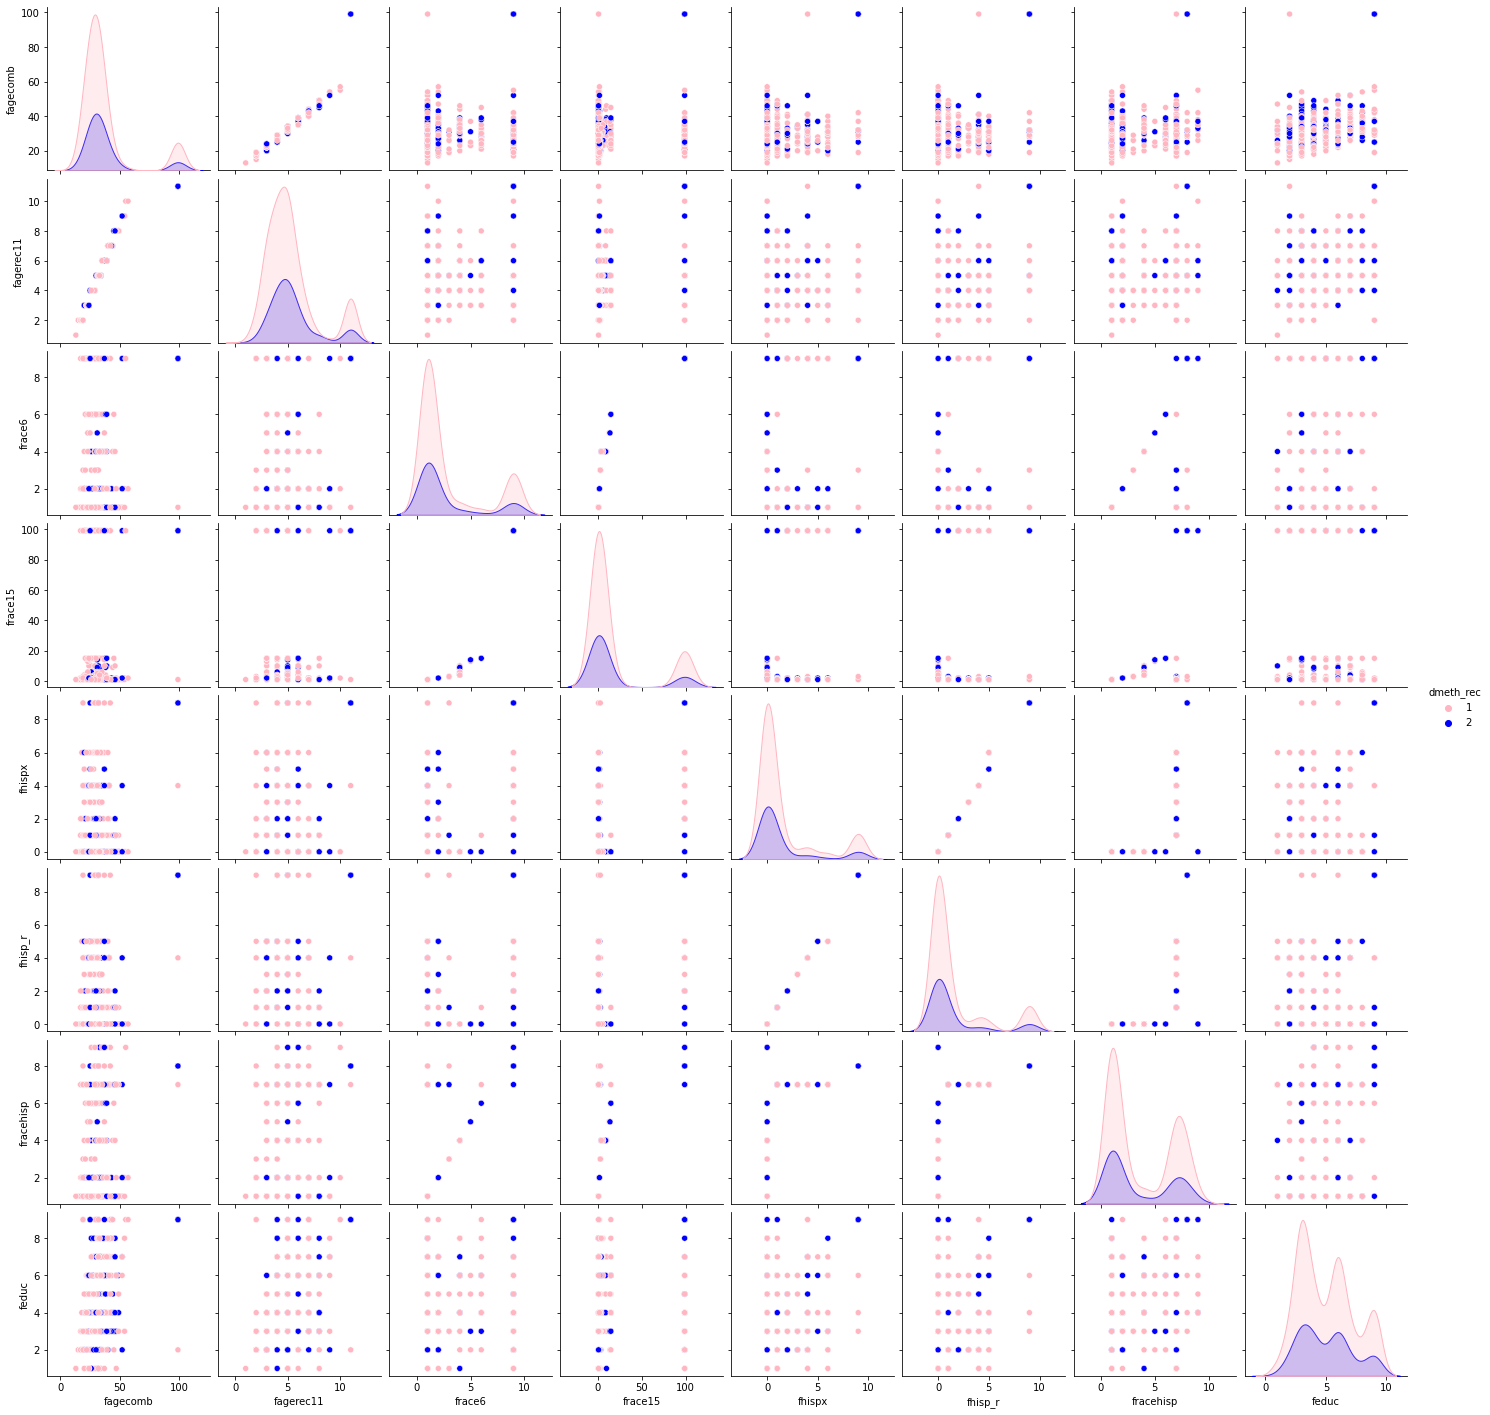

In [ ]:
#view features related to father
sns.pairplot(data=father.sample(1000), palette=colors, hue='dmeth_rec')
plt.show()